# Model Notebook

### Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import scipy.stats as st
import math
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import r2_score
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from math import sqrt

# suppress futurewarnings from statistical packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.ticker as mticker
from tabulate import tabulate
import plotly
import plotly.express as px

#read data

zip_file = "../Dataset/AB_US_2020.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("../Dataset/unZipped/")
        print("Extracted all")
except:
    print("Invalid file")
    
airbnbDS = pd.read_csv("../Dataset/unZipped/AB_US_2020.csv")

#Going to drop neighbourhood_group because of half of the values are null. For both name and host name I will fill the
#empty slots with "N/A", there is very few missing and I do not think name will be very important to regesion on price.
#For all null values in reviews_per_month will be replaced with 0.


airbnbDS = airbnbDS.drop("neighbourhood_group", axis = 1)


airbnbDS = airbnbDS.fillna(value= {'name': 'N/A', 'host_name':'N/A', 'reviews_per_month': 0})

airbnbDS = airbnbDS.dropna()

room_ID_dic = {'Entire home/apt': 1, 'Private room': 2,'Shared room': 3, 'Hotel room': 4}

airbnbDS['room_type_ID'] = airbnbDS['room_type'].apply(lambda x: room_ID_dic[x])

city_ID_dic = {'Asheville' : 1, 'Austin' : 2, 'Boston' :3, 'Broward County' :4, 'Cambridge':5,
       'Chicago':6, 'Clark County':7, 'Columbus':8, 'Denver':9, 'Hawaii':10,
       'Jersey City':11, 'Los Angeles':12, 'Nashville':13, 'New Orleans':14,
       'New York City':15, 'Oakland':16, 'Pacific Grove':17, 'Portland':18,
       'Rhode Island':19, 'Salem':20, 'San Clara Country':21, 'San Diego':22,
       'San Francisco':23, 'San Mateo County':24, 'Santa Cruz County':25,
       'Seattle':26, 'Twin Cities MSA':27, 'Washington D.C.':28}


airbnbDS['city_ID'] = airbnbDS['city'].apply(lambda x: city_ID_dic[x])

airbnbDS["Profit"] = airbnbDS['price'] * (airbnbDS['availability_365'])

airbnbDS['last_review'] = pd.to_datetime(airbnbDS['last_review'])

airbnbDS['days_since_last_review'] = datetime.now() - airbnbDS['last_review']

airbnbDS['days_since_last_review'] = airbnbDS['days_since_last_review'].dt.days

airbnbDS = airbnbDS.drop('last_review', axis =1)


Extracted all


C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
airbnbDS

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city,room_type_ID,city_ID,Profit,days_since_last_review
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,28804,35.65146,-82.62792,Private room,60,1,138,1.14,1,0,Asheville,2,1,0,1062
1,80905,French Chic Loft,427027,Celeste,28801,35.59779,-82.55540,Entire home/apt,470,1,114,1.03,11,288,Asheville,1,1,135360,918
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,28801,35.60670,-82.55563,Entire home/apt,75,30,89,0.81,2,298,Asheville,1,1,22350,1140
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,90,1,267,2.39,5,0,Asheville,1,1,0,843
4,160594,Historic Grove Park,769252,Elizabeth,28801,35.61442,-82.54127,Private room,125,30,58,0.52,1,0,Asheville,2,1,0,2643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225936,45326130,Modern and cozy home located in Washington DC,55489711,Amir,"Union Station, Stanton Park, Kingman Park",38.90101,-77.00283,Entire home/apt,144,1,1,1.00,1,328,Washington D.C.,1,28,47232,847
225950,45349877,Penthouse w/ Patio ‚òÜ Capitol Hill Condo ‚òÜ ...,3850096,Ije,"Capitol Hill, Lincoln Park",38.88703,-77.00586,Entire home/apt,132,2,1,1.00,8,162,Washington D.C.,1,28,21384,849
225955,45352724,MODERN ‚òÜ Well-Located Shaw Town Home ‚òÜ 2BR...,3850096,Ije,"Howard University, Le Droit Park, Cardozo/Shaw",38.91626,-77.02074,Entire home/apt,112,2,1,1.00,8,171,Washington D.C.,1,28,19152,852
225964,45385834,Brand new modern apartment with private entry,16561471,Victor,"Brightwood Park, Crestwood, Petworth",38.94358,-77.01283,Entire home/apt,78,1,1,1.00,1,75,Washington D.C.,1,28,5850,846


In [3]:
airbnbDS

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city,room_type_ID,city_ID,Profit,days_since_last_review
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,28804,35.65146,-82.62792,Private room,60,1,138,1.14,1,0,Asheville,2,1,0,1062
1,80905,French Chic Loft,427027,Celeste,28801,35.59779,-82.55540,Entire home/apt,470,1,114,1.03,11,288,Asheville,1,1,135360,918
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,28801,35.60670,-82.55563,Entire home/apt,75,30,89,0.81,2,298,Asheville,1,1,22350,1140
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,90,1,267,2.39,5,0,Asheville,1,1,0,843
4,160594,Historic Grove Park,769252,Elizabeth,28801,35.61442,-82.54127,Private room,125,30,58,0.52,1,0,Asheville,2,1,0,2643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225936,45326130,Modern and cozy home located in Washington DC,55489711,Amir,"Union Station, Stanton Park, Kingman Park",38.90101,-77.00283,Entire home/apt,144,1,1,1.00,1,328,Washington D.C.,1,28,47232,847
225950,45349877,Penthouse w/ Patio ‚òÜ Capitol Hill Condo ‚òÜ ...,3850096,Ije,"Capitol Hill, Lincoln Park",38.88703,-77.00586,Entire home/apt,132,2,1,1.00,8,162,Washington D.C.,1,28,21384,849
225955,45352724,MODERN ‚òÜ Well-Located Shaw Town Home ‚òÜ 2BR...,3850096,Ije,"Howard University, Le Droit Park, Cardozo/Shaw",38.91626,-77.02074,Entire home/apt,112,2,1,1.00,8,171,Washington D.C.,1,28,19152,852
225964,45385834,Brand new modern apartment with private entry,16561471,Victor,"Brightwood Park, Crestwood, Petworth",38.94358,-77.01283,Entire home/apt,78,1,1,1.00,1,75,Washington D.C.,1,28,5850,846


In [4]:
airbnbDS.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_ID,city_ID,Profit,days_since_last_review
count,1.774280e+05,1.774280e+05,177428.000000,177428.000000,177428.000000,1.774280e+05,177428.000000,177428.00000,177428.000000,177428.000000,177428.000000,177428.000000,1.774280e+05,177428.000000
mean,2.349823e+07,8.449619e+07,35.728741,-103.247427,184.520188,5.723698e+02,43.958738,1.43145,11.391404,157.951518,1.343029,14.056958,3.195856e+04,1167.717311
std,1.263624e+07,9.067049e+07,6.789461,25.967295,430.596928,2.374045e+05,68.832735,1.68321,33.375799,138.129585,0.552196,6.873973,8.736572e+04,402.127897
min,1.090000e+02,2.300000e+01,18.920990,-159.714900,0.000000,1.000000e+00,1.000000,0.01000,1.000000,0.000000,1.000000,1.000000,0.000000e+00,765.000000
25%,1.368938e+07,1.212612e+07,32.770550,-121.570070,75.000000,1.000000e+00,4.000000,0.23000,1.000000,1.000000,1.000000,10.000000,1.250000e+02,918.000000
50%,2.338574e+07,4.673526e+07,37.259625,-104.874350,116.000000,2.000000e+00,16.000000,0.81000,2.000000,139.000000,1.000000,14.000000,1.350000e+04,1036.000000
75%,3.446794e+07,1.339236e+08,40.722143,-76.987305,195.000000,5.000000e+00,54.000000,2.06000,5.000000,305.000000,2.000000,18.000000,3.613500e+04,1229.000000
max,4.549250e+07,3.679176e+08,47.734620,-70.995950,24999.000000,1.000000e+08,966.000000,44.06000,393.000000,365.000000,4.000000,28.000000,6.449742e+06,4674.000000


## Dummy variables

In [5]:
airbnbDS.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
city                               object
room_type_ID                        int64
city_ID                             int64
Profit                              int64
days_since_last_review              int64
dtype: object

Copying the panda frame to sets to run against differnt models

In [6]:
modelDS = airbnbDS.copy()
modelRF = airbnbDS.copy()

In [7]:
modelRF

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city,room_type_ID,city_ID,Profit,days_since_last_review
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,28804,35.65146,-82.62792,Private room,60,1,138,1.14,1,0,Asheville,2,1,0,1062
1,80905,French Chic Loft,427027,Celeste,28801,35.59779,-82.55540,Entire home/apt,470,1,114,1.03,11,288,Asheville,1,1,135360,918
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,28801,35.60670,-82.55563,Entire home/apt,75,30,89,0.81,2,298,Asheville,1,1,22350,1140
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,28806,35.57864,-82.59578,Entire home/apt,90,1,267,2.39,5,0,Asheville,1,1,0,843
4,160594,Historic Grove Park,769252,Elizabeth,28801,35.61442,-82.54127,Private room,125,30,58,0.52,1,0,Asheville,2,1,0,2643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225936,45326130,Modern and cozy home located in Washington DC,55489711,Amir,"Union Station, Stanton Park, Kingman Park",38.90101,-77.00283,Entire home/apt,144,1,1,1.00,1,328,Washington D.C.,1,28,47232,847
225950,45349877,Penthouse w/ Patio ‚òÜ Capitol Hill Condo ‚òÜ ...,3850096,Ije,"Capitol Hill, Lincoln Park",38.88703,-77.00586,Entire home/apt,132,2,1,1.00,8,162,Washington D.C.,1,28,21384,849
225955,45352724,MODERN ‚òÜ Well-Located Shaw Town Home ‚òÜ 2BR...,3850096,Ije,"Howard University, Le Droit Park, Cardozo/Shaw",38.91626,-77.02074,Entire home/apt,112,2,1,1.00,8,171,Washington D.C.,1,28,19152,852
225964,45385834,Brand new modern apartment with private entry,16561471,Victor,"Brightwood Park, Crestwood, Petworth",38.94358,-77.01283,Entire home/apt,78,1,1,1.00,1,75,Washington D.C.,1,28,5850,846


removing the columns that we will not use in the model

In [8]:
modelDS = modelDS.drop('id', axis =1)
modelDS = modelDS.drop('name', axis =1)
modelDS = modelDS.drop('host_id', axis =1)
modelDS = modelDS.drop('host_name', axis =1)
modelDS = modelDS.drop('neighbourhood', axis =1)
modelDS = modelDS.drop('room_type', axis =1)
modelDS = modelDS.drop('city', axis =1)

modelRF = modelRF.drop('id', axis =1)
modelRF = modelRF.drop('name', axis =1)
modelRF = modelRF.drop('host_id', axis =1)
modelRF = modelRF.drop('host_name', axis =1)
modelRF = modelRF.drop('neighbourhood', axis =1)
modelRF = modelRF.drop('room_type', axis =1)
modelRF = modelRF.drop('city', axis =1)

In [9]:
modelDS

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_ID,city_ID,Profit,days_since_last_review
0,35.65146,-82.62792,60,1,138,1.14,1,0,2,1,0,1062
1,35.59779,-82.55540,470,1,114,1.03,11,288,1,1,135360,918
2,35.60670,-82.55563,75,30,89,0.81,2,298,1,1,22350,1140
3,35.57864,-82.59578,90,1,267,2.39,5,0,1,1,0,843
4,35.61442,-82.54127,125,30,58,0.52,1,0,2,1,0,2643
...,...,...,...,...,...,...,...,...,...,...,...,...
225936,38.90101,-77.00283,144,1,1,1.00,1,328,1,28,47232,847
225950,38.88703,-77.00586,132,2,1,1.00,8,162,1,28,21384,849
225955,38.91626,-77.02074,112,2,1,1.00,8,171,1,28,19152,852
225964,38.94358,-77.01283,78,1,1,1.00,1,75,1,28,5850,846


In [10]:
modelDS.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_ID,city_ID,Profit,days_since_last_review
latitude,1.000000,0.558152,-0.058386,0.000711,0.050037,0.053906,-0.203682,-0.177410,0.138919,0.448815,-0.100235,0.119590
longitude,0.558152,1.000000,-0.049598,-0.001756,-0.040210,-0.021908,-0.213236,-0.148488,0.112847,-0.046814,-0.078700,0.126213
price,-0.058386,-0.049598,1.000000,-0.000642,-0.060874,-0.055226,0.076714,0.047300,-0.122937,-0.004054,0.701144,0.002119
minimum_nights,0.000711,-0.001756,-0.000642,1.000000,-0.001247,-0.001790,-0.000738,-0.002710,0.002822,0.003087,-0.000868,0.005172
number_of_reviews,0.050037,-0.040210,-0.060874,-0.001247,1.000000,0.732273,-0.113825,0.068520,-0.039671,0.040011,-0.041179,-0.255399
reviews_per_month,0.053906,-0.021908,-0.055226,-0.001790,0.732273,1.000000,-0.113099,0.043291,-0.074901,0.007045,-0.041754,-0.389714
calculated_host_listings_count,-0.203682,-0.213236,0.076714,-0.000738,-0.113825,-0.113099,1.000000,0.132094,-0.089915,-0.032374,0.081964,-0.047839
availability_365,-0.177410,-0.148488,0.047300,-0.002710,0.068520,0.043291,0.132094,1.000000,-0.025836,-0.081520,0.331318,-0.241980
room_type_ID,0.138919,0.112847,-0.122937,0.002822,-0.039671,-0.074901,-0.089915,-0.025836,1.000000,0.053049,-0.108787,0.088162
city_ID,0.448815,-0.046814,-0.004054,0.003087,0.040011,0.007045,-0.032374,-0.081520,0.053049,1.000000,-0.036314,0.067814


#  Removing Outliers

In [11]:
lower_bound = .0
upper_bound = .95
modelDS = modelDS[modelDS['price'].between(modelDS['price'].quantile(lower_bound), \
            modelDS['price'].quantile(upper_bound), inclusive=True)].reset_index(drop=True)
modelRF = modelRF[modelRF['price'].between(modelRF['price'].quantile(lower_bound), \
            modelRF['price'].quantile(upper_bound), inclusive=True)].reset_index(drop=True)

In [12]:
modelDS.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_ID,city_ID,Profit,days_since_last_review
count,168601.000000,168601.000000,168601.000000,1.686010e+05,168601.000000,168601.000000,168601.000000,168601.000000,168601.000000,168601.000000,168601.000000,168601.000000
mean,35.821908,-102.948702,136.768293,6.019266e+02,45.184495,1.463621,11.049662,155.483651,1.356243,14.070777,22526.028837,1166.384529
std,6.761705,25.924187,90.523192,2.435398e+05,69.986867,1.703096,32.938092,137.842529,0.556009,6.845154,28388.630995,401.778559
min,18.920990,-159.711430,0.000000,1.000000e+00,1.000000,0.010000,1.000000,0.000000,1.000000,1.000000,0.000000,765.000000
25%,32.787190,-118.769200,71.000000,1.000000e+00,4.000000,0.240000,1.000000,0.000000,1.000000,10.000000,0.000000,918.000000
50%,37.327550,-97.846830,110.000000,2.000000e+00,17.000000,0.840000,2.000000,133.000000,1.000000,14.000000,12540.000000,1036.000000
75%,40.723330,-74.105750,176.000000,5.000000e+00,56.000000,2.120000,5.000000,301.000000,2.000000,18.000000,32850.000000,1221.000000
max,47.734620,-70.995950,485.000000,1.000000e+08,966.000000,44.060000,393.000000,365.000000,4.000000,28.000000,176540.000000,4674.000000


In [13]:
modelDS.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_ID,city_ID,Profit,days_since_last_review
latitude,1.000000,0.553455,-0.156597,0.000698,0.044832,0.047590,-0.195017,-0.178087,0.137515,0.445939,-0.222970,0.122307
longitude,0.553455,1.000000,-0.128875,-0.001832,-0.047516,-0.030031,-0.208212,-0.150665,0.110958,-0.049406,-0.179262,0.130379
price,-0.156597,-0.128875,1.000000,-0.001853,-0.092055,-0.105320,0.119947,0.101042,-0.395118,-0.023344,0.612908,-0.009797
minimum_nights,0.000698,-0.001832,-0.001853,1.000000,-0.001300,-0.001861,-0.000741,-0.002742,0.002817,0.003175,-0.001932,0.005318
number_of_reviews,0.044832,-0.047516,-0.092055,-0.001300,1.000000,0.732630,-0.111611,0.076069,-0.048729,0.041066,-0.007781,-0.257506
reviews_per_month,0.047590,-0.030031,-0.105320,-0.001861,0.732630,1.000000,-0.110781,0.051196,-0.085957,0.007297,-0.027502,-0.391760
calculated_host_listings_count,-0.195017,-0.208212,0.119947,-0.000741,-0.111611,-0.110781,1.000000,0.132991,-0.089823,-0.032554,0.164870,-0.048561
availability_365,-0.178087,-0.150665,0.101042,-0.002742,0.076069,0.051196,0.132991,1.000000,-0.017648,-0.080806,0.715152,-0.249476
room_type_ID,0.137515,0.110958,-0.395118,0.002817,-0.048729,-0.085957,-0.089823,-0.017648,1.000000,0.054731,-0.215720,0.090986
city_ID,0.445939,-0.049406,-0.023344,0.003175,0.041066,0.007297,-0.032554,-0.080806,0.054731,1.000000,-0.073094,0.067646


In [14]:
modelDS.shape

(168601, 12)

#  Model

### Decision Tree 

In [15]:
X = modelRF.drop('price', axis = 1)
y = modelRF['price']

scaler = StandardScaler()
X =scaler.fit_transform(X)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)


rf_model = DecisionTreeRegressor()
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.7231531607088446

In [16]:
SEED = 1
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [17]:
y_true = np.array(y_test, dtype=np.float64)
y_pred = np.array(dt.predict(X_test), dtype=np.float64)

print("MSE Score: {:.4f}" .format(mean_squared_error(y_true, y_pred)))
print("RMSE Score: {:.4f}" .format(sqrt(mean_squared_error(y_true, y_pred))))

MSE Score: 2382.0976
RMSE Score: 48.8067


Visulization of the decision tree

*** Warning: this line of code takes 3.5 hours to run ***

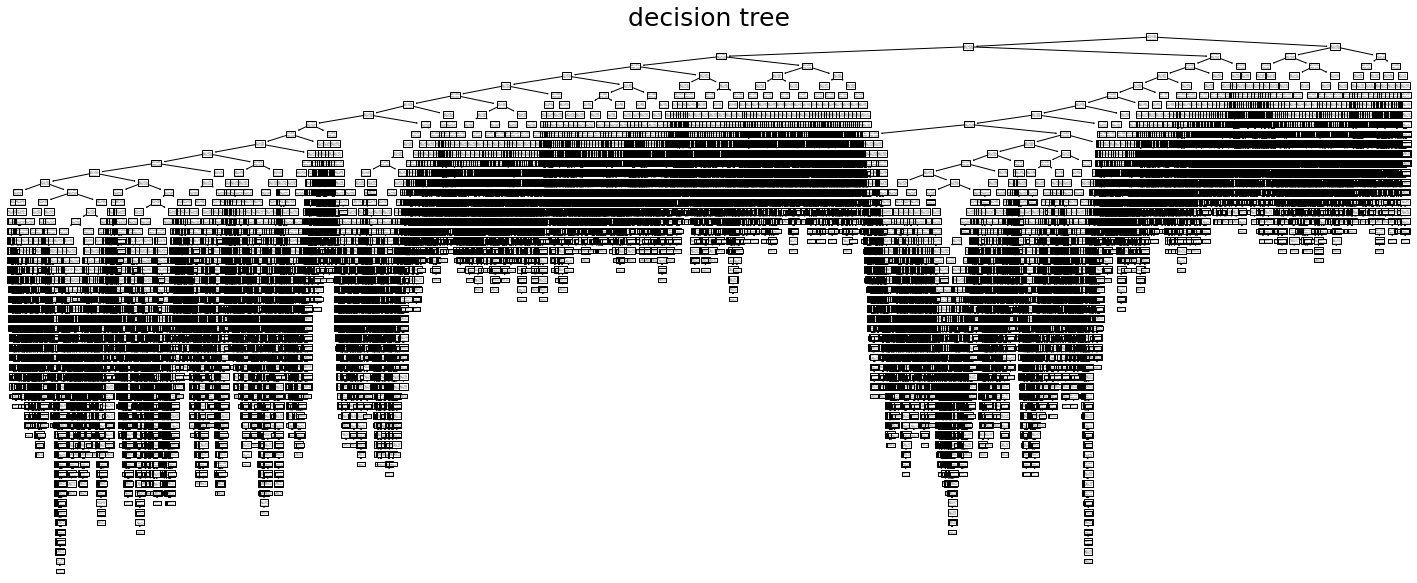

In [18]:
from sklearn.tree import plot_tree
plt.figure(figsize = (25,10))
plot_tree(rf_model)
plt.title("decision tree", fontsize = 25)

plt.show()

scatter plot to the correlations of the results

<AxesSubplot:>

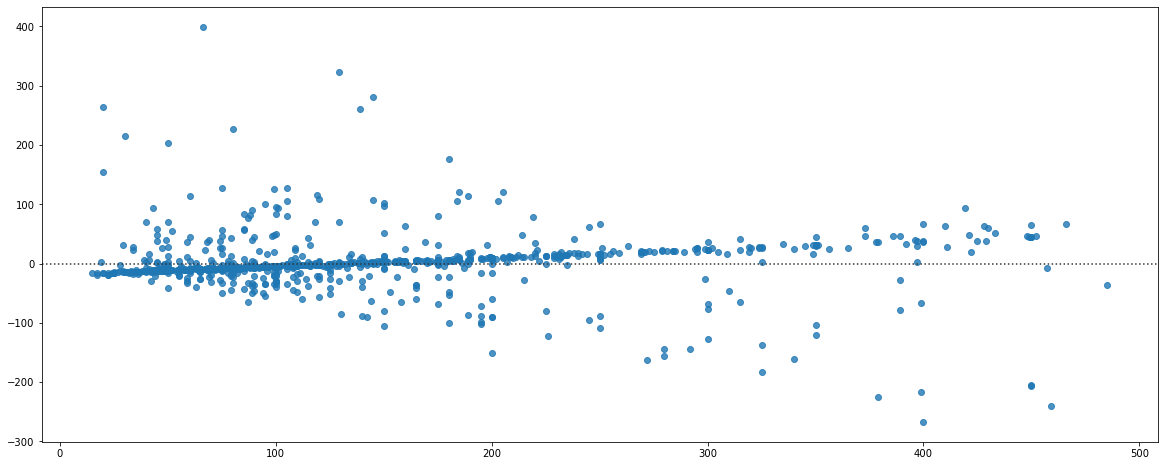

In [19]:
plt.figure(figsize=(20,8))
sns.residplot(x=y_test[:1000],y=y_pred[:1000])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00,
        0.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 9.0000e+00, 5.0000e+00, 1.4000e+01, 6.0000e+00,
        7.0000e+00, 1.3000e+01, 1.1000e+01, 1.7000e+01, 2.1000e+01,
        2.2000e+01, 2.2000e+01, 1.7000e+01, 2.3000e+01, 2.5000e+01,
        2.3000e+01, 2.7000e+01, 4.6000e+01, 4.1000e+01, 4.7000e+01,
        4.6000e+01, 7.3000e+01, 6.0000e+01, 7.4000e+01, 8.9000e+01,
        8.7000e+01, 9.9000e+01, 1.3300e+02, 1.4500e+02, 1.1700e+02,
        2.1700e+02, 2.5300e+02, 2.6100e+02, 3.1100e+02, 4.0800e+02,
        6.0200e+02, 7.7900e+02, 1.2850e+03, 2.1379e+04, 2.5210e+03,
        8.7700e+02, 5.1800e+02, 4.6500e+02, 3.7800e+02, 3.0400e+02,
        2.4300e+02, 1.9700e+02, 1.8400e+02, 1.2000e+02, 1.0100e+02,
        1.2000e+02, 9.9000e+01, 6.6000e+01, 8.9000e+01, 6.2000e+01,
        3.9000e+01, 6.2000e+01, 3.5000e+01, 5.1000e+01, 2.4000e+01,
        2.8000e+01, 3.5000e+01, 3.2000e+01, 2.20

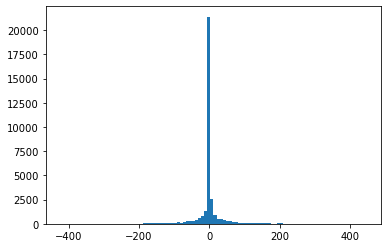

In [20]:
d=y_pred-y_test

plt.hist(d, bins=100)

### XGBoost

In [21]:
X = modelDS.drop('price', axis = 1)
y = modelDS['price']

In [22]:
scaler = StandardScaler()
X =scaler.fit_transform(X)

X = np.array(X)
y = np.array(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state =20 )

In [27]:
xgModel = XGBRegressor()
xgModel.fit(X_train, y_train)
xgModel.score(X_test,y_test)

0.866797932075264

In [28]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(X_test, label = y_test)

In [29]:
params = {'learning_rate': 0.001, 'max_depth':6}
model = xgb.train(params, dtrain,evals=[(dval, 'eval')], num_boost_round = 10000, early_stopping_rounds = 10)

[0]	eval-rmse:162.99585
Will train until eval-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:162.84778
[2]	eval-rmse:162.69957
[3]	eval-rmse:162.55165
[4]	eval-rmse:162.40392
[5]	eval-rmse:162.25630
[6]	eval-rmse:162.10866
[7]	eval-rmse:161.96162
[8]	eval-rmse:161.81429
[9]	eval-rmse:161.66762
[10]	eval-rmse:161.52068
[11]	eval-rmse:161.37413
[12]	eval-rmse:161.22760
[13]	eval-rmse:161.08128
[14]	eval-rmse:160.93520
[15]	eval-rmse:160.78920
[16]	eval-rmse:160.64325
[17]	eval-rmse:160.49760
[18]	eval-rmse:160.35204
[19]	eval-rmse:160.20674
[20]	eval-rmse:160.06152
[21]	eval-rmse:159.91649
[22]	eval-rmse:159.77150
[23]	eval-rmse:159.62676
[24]	eval-rmse:159.48236
[25]	eval-rmse:159.33781
[26]	eval-rmse:159.19351
[27]	eval-rmse:159.04944
[28]	eval-rmse:158.90547
[29]	eval-rmse:158.76170
[30]	eval-rmse:158.61789
[31]	eval-rmse:158.47440
[32]	eval-rmse:158.33105
[33]	eval-rmse:158.18779
[34]	eval-rmse:158.04472
[35]	eval-rmse:157.90195
[36]	eval-rmse:157.75900
[37]	eval-rmse:157.61662
[38

[318]	eval-rmse:123.04466
[319]	eval-rmse:122.93937
[320]	eval-rmse:122.83514
[321]	eval-rmse:122.72977
[322]	eval-rmse:122.62455
[323]	eval-rmse:122.52001
[324]	eval-rmse:122.41522
[325]	eval-rmse:122.31042
[326]	eval-rmse:122.20684
[327]	eval-rmse:122.10235
[328]	eval-rmse:121.99782
[329]	eval-rmse:121.89475
[330]	eval-rmse:121.79056
[331]	eval-rmse:121.68660
[332]	eval-rmse:121.58388
[333]	eval-rmse:121.47987
[334]	eval-rmse:121.37595
[335]	eval-rmse:121.27322
[336]	eval-rmse:121.16957
[337]	eval-rmse:121.06735
[338]	eval-rmse:120.96397
[339]	eval-rmse:120.86067
[340]	eval-rmse:120.75889
[341]	eval-rmse:120.65585
[342]	eval-rmse:120.55297
[343]	eval-rmse:120.45094
[344]	eval-rmse:120.34832
[345]	eval-rmse:120.24705
[346]	eval-rmse:120.14445
[347]	eval-rmse:120.04220
[348]	eval-rmse:119.93992
[349]	eval-rmse:119.83911
[350]	eval-rmse:119.73708
[351]	eval-rmse:119.63633
[352]	eval-rmse:119.53462
[353]	eval-rmse:119.43293
[354]	eval-rmse:119.33234
[355]	eval-rmse:119.23082
[356]	eval-r

[636]	eval-rmse:94.85239
[637]	eval-rmse:94.77883
[638]	eval-rmse:94.70648
[639]	eval-rmse:94.63218
[640]	eval-rmse:94.55837
[641]	eval-rmse:94.48431
[642]	eval-rmse:94.41257
[643]	eval-rmse:94.33849
[644]	eval-rmse:94.26466
[645]	eval-rmse:94.19117
[646]	eval-rmse:94.11776
[647]	eval-rmse:94.04417
[648]	eval-rmse:93.97165
[649]	eval-rmse:93.90018
[650]	eval-rmse:93.82666
[651]	eval-rmse:93.75363
[652]	eval-rmse:93.68272
[653]	eval-rmse:93.61063
[654]	eval-rmse:93.53757
[655]	eval-rmse:93.46510
[656]	eval-rmse:93.39223
[657]	eval-rmse:93.31955
[658]	eval-rmse:93.24794
[659]	eval-rmse:93.17738
[660]	eval-rmse:93.10490
[661]	eval-rmse:93.03293
[662]	eval-rmse:92.96062
[663]	eval-rmse:92.88831
[664]	eval-rmse:92.81818
[665]	eval-rmse:92.74611
[666]	eval-rmse:92.67637
[667]	eval-rmse:92.60570
[668]	eval-rmse:92.53376
[669]	eval-rmse:92.46260
[670]	eval-rmse:92.39094
[671]	eval-rmse:92.31949
[672]	eval-rmse:92.24805
[673]	eval-rmse:92.17858
[674]	eval-rmse:92.10738
[675]	eval-rmse:92.03662


[964]	eval-rmse:74.76002
[965]	eval-rmse:74.70927
[966]	eval-rmse:74.65860
[967]	eval-rmse:74.60980
[968]	eval-rmse:74.55932
[969]	eval-rmse:74.51122
[970]	eval-rmse:74.46148
[971]	eval-rmse:74.41112
[972]	eval-rmse:74.36085
[973]	eval-rmse:74.31237
[974]	eval-rmse:74.26224
[975]	eval-rmse:74.21294
[976]	eval-rmse:74.16294
[977]	eval-rmse:74.11364
[978]	eval-rmse:74.06593
[979]	eval-rmse:74.01620
[980]	eval-rmse:73.96703
[981]	eval-rmse:73.91910
[982]	eval-rmse:73.86944
[983]	eval-rmse:73.81996
[984]	eval-rmse:73.77050
[985]	eval-rmse:73.72278
[986]	eval-rmse:73.67567
[987]	eval-rmse:73.62637
[988]	eval-rmse:73.57790
[989]	eval-rmse:73.52869
[990]	eval-rmse:73.47949
[991]	eval-rmse:73.43246
[992]	eval-rmse:73.38393
[993]	eval-rmse:73.33508
[994]	eval-rmse:73.28825
[995]	eval-rmse:73.23955
[996]	eval-rmse:73.19222
[997]	eval-rmse:73.14546
[998]	eval-rmse:73.09683
[999]	eval-rmse:73.04989
[1000]	eval-rmse:73.00133
[1001]	eval-rmse:72.95483
[1002]	eval-rmse:72.90642
[1003]	eval-rmse:72.86

[1281]	eval-rmse:61.69902
[1282]	eval-rmse:61.66605
[1283]	eval-rmse:61.63216
[1284]	eval-rmse:61.59837
[1285]	eval-rmse:61.56657
[1286]	eval-rmse:61.53325
[1287]	eval-rmse:61.49957
[1288]	eval-rmse:61.46668
[1289]	eval-rmse:61.43306
[1290]	eval-rmse:61.40105
[1291]	eval-rmse:61.36753
[1292]	eval-rmse:61.33444
[1293]	eval-rmse:61.30314
[1294]	eval-rmse:61.26981
[1295]	eval-rmse:61.23678
[1296]	eval-rmse:61.20443
[1297]	eval-rmse:61.17113
[1298]	eval-rmse:61.13867
[1299]	eval-rmse:61.10548
[1300]	eval-rmse:61.07241
[1301]	eval-rmse:61.04147
[1302]	eval-rmse:61.00849
[1303]	eval-rmse:60.97708
[1304]	eval-rmse:60.94445
[1305]	eval-rmse:60.91160
[1306]	eval-rmse:60.87913
[1307]	eval-rmse:60.84813
[1308]	eval-rmse:60.81542
[1309]	eval-rmse:60.78405
[1310]	eval-rmse:60.75133
[1311]	eval-rmse:60.72018
[1312]	eval-rmse:60.68763
[1313]	eval-rmse:60.65700
[1314]	eval-rmse:60.62472
[1315]	eval-rmse:60.59231
[1316]	eval-rmse:60.56071
[1317]	eval-rmse:60.52829
[1318]	eval-rmse:60.49601
[1319]	eval-

[1597]	eval-rmse:53.15554
[1598]	eval-rmse:53.13449
[1599]	eval-rmse:53.11298
[1600]	eval-rmse:53.09170
[1601]	eval-rmse:53.07052
[1602]	eval-rmse:53.04895
[1603]	eval-rmse:53.02808
[1604]	eval-rmse:53.00632
[1605]	eval-rmse:52.98470
[1606]	eval-rmse:52.96340
[1607]	eval-rmse:52.94161
[1608]	eval-rmse:52.92075
[1609]	eval-rmse:52.89941
[1610]	eval-rmse:52.87821
[1611]	eval-rmse:52.85653
[1612]	eval-rmse:52.83623
[1613]	eval-rmse:52.81480
[1614]	eval-rmse:52.79346
[1615]	eval-rmse:52.77271
[1616]	eval-rmse:52.75115
[1617]	eval-rmse:52.73014
[1618]	eval-rmse:52.70910
[1619]	eval-rmse:52.68868
[1620]	eval-rmse:52.66736
[1621]	eval-rmse:52.64624
[1622]	eval-rmse:52.62580
[1623]	eval-rmse:52.60485
[1624]	eval-rmse:52.58361
[1625]	eval-rmse:52.56392
[1626]	eval-rmse:52.54330
[1627]	eval-rmse:52.52218
[1628]	eval-rmse:52.50177
[1629]	eval-rmse:52.48105
[1630]	eval-rmse:52.46038
[1631]	eval-rmse:52.43979
[1632]	eval-rmse:52.41858
[1633]	eval-rmse:52.39860
[1634]	eval-rmse:52.37801
[1635]	eval-

[1913]	eval-rmse:47.65959
[1914]	eval-rmse:47.64611
[1915]	eval-rmse:47.63207
[1916]	eval-rmse:47.61859
[1917]	eval-rmse:47.60522
[1918]	eval-rmse:47.59120
[1919]	eval-rmse:47.57867
[1920]	eval-rmse:47.56477
[1921]	eval-rmse:47.55073
[1922]	eval-rmse:47.53743
[1923]	eval-rmse:47.52342
[1924]	eval-rmse:47.51023
[1925]	eval-rmse:47.49685
[1926]	eval-rmse:47.48299
[1927]	eval-rmse:47.46925
[1928]	eval-rmse:47.45535
[1929]	eval-rmse:47.44201
[1930]	eval-rmse:47.42820
[1931]	eval-rmse:47.41444
[1932]	eval-rmse:47.40127
[1933]	eval-rmse:47.38825
[1934]	eval-rmse:47.37534
[1935]	eval-rmse:47.36165
[1936]	eval-rmse:47.34853
[1937]	eval-rmse:47.33490
[1938]	eval-rmse:47.32126
[1939]	eval-rmse:47.30774
[1940]	eval-rmse:47.29558
[1941]	eval-rmse:47.28205
[1942]	eval-rmse:47.26846
[1943]	eval-rmse:47.25482
[1944]	eval-rmse:47.24189
[1945]	eval-rmse:47.22839
[1946]	eval-rmse:47.21591
[1947]	eval-rmse:47.20236
[1948]	eval-rmse:47.18882
[1949]	eval-rmse:47.17598
[1950]	eval-rmse:47.16249
[1951]	eval-

[2229]	eval-rmse:44.15977
[2230]	eval-rmse:44.15109
[2231]	eval-rmse:44.14326
[2232]	eval-rmse:44.13461
[2233]	eval-rmse:44.12552
[2234]	eval-rmse:44.11718
[2235]	eval-rmse:44.10870
[2236]	eval-rmse:44.10011
[2237]	eval-rmse:44.09163
[2238]	eval-rmse:44.08306
[2239]	eval-rmse:44.07455
[2240]	eval-rmse:44.06599
[2241]	eval-rmse:44.05756
[2242]	eval-rmse:44.04907
[2243]	eval-rmse:44.04008
[2244]	eval-rmse:44.03190
[2245]	eval-rmse:44.02353
[2246]	eval-rmse:44.01507
[2247]	eval-rmse:44.00676
[2248]	eval-rmse:43.99834
[2249]	eval-rmse:43.98994
[2250]	eval-rmse:43.98166
[2251]	eval-rmse:43.97360
[2252]	eval-rmse:43.96523
[2253]	eval-rmse:43.95699
[2254]	eval-rmse:43.94874
[2255]	eval-rmse:43.94051
[2256]	eval-rmse:43.93212
[2257]	eval-rmse:43.92385
[2258]	eval-rmse:43.91557
[2259]	eval-rmse:43.90730
[2260]	eval-rmse:43.89933
[2261]	eval-rmse:43.89120
[2262]	eval-rmse:43.88297
[2263]	eval-rmse:43.87485
[2264]	eval-rmse:43.86674
[2265]	eval-rmse:43.85857
[2266]	eval-rmse:43.85073
[2267]	eval-

[2545]	eval-rmse:41.87323
[2546]	eval-rmse:41.86721
[2547]	eval-rmse:41.86164
[2548]	eval-rmse:41.85563
[2549]	eval-rmse:41.84951
[2550]	eval-rmse:41.84339
[2551]	eval-rmse:41.83789
[2552]	eval-rmse:41.83240
[2553]	eval-rmse:41.82628
[2554]	eval-rmse:41.82059
[2555]	eval-rmse:41.81480
[2556]	eval-rmse:41.80827
[2557]	eval-rmse:41.80221
[2558]	eval-rmse:41.79689
[2559]	eval-rmse:41.79146
[2560]	eval-rmse:41.78479
[2561]	eval-rmse:41.77939
[2562]	eval-rmse:41.77376
[2563]	eval-rmse:41.76802
[2564]	eval-rmse:41.76264
[2565]	eval-rmse:41.75666
[2566]	eval-rmse:41.75068
[2567]	eval-rmse:41.74481
[2568]	eval-rmse:41.73946
[2569]	eval-rmse:41.73425
[2570]	eval-rmse:41.72866
[2571]	eval-rmse:41.72273
[2572]	eval-rmse:41.71743
[2573]	eval-rmse:41.71212
[2574]	eval-rmse:41.70563
[2575]	eval-rmse:41.70031
[2576]	eval-rmse:41.69505
[2577]	eval-rmse:41.68925
[2578]	eval-rmse:41.68392
[2579]	eval-rmse:41.67864
[2580]	eval-rmse:41.67313
[2581]	eval-rmse:41.66790
[2582]	eval-rmse:41.66160
[2583]	eval-

[2861]	eval-rmse:40.26557
[2862]	eval-rmse:40.26209
[2863]	eval-rmse:40.25753
[2864]	eval-rmse:40.25355
[2865]	eval-rmse:40.24907
[2866]	eval-rmse:40.24479
[2867]	eval-rmse:40.24023
[2868]	eval-rmse:40.23569
[2869]	eval-rmse:40.23121
[2870]	eval-rmse:40.22695
[2871]	eval-rmse:40.22292
[2872]	eval-rmse:40.21849
[2873]	eval-rmse:40.21403
[2874]	eval-rmse:40.20952
[2875]	eval-rmse:40.20530
[2876]	eval-rmse:40.20114
[2877]	eval-rmse:40.19673
[2878]	eval-rmse:40.19282
[2879]	eval-rmse:40.18863
[2880]	eval-rmse:40.18461
[2881]	eval-rmse:40.18042
[2882]	eval-rmse:40.17623
[2883]	eval-rmse:40.17284
[2884]	eval-rmse:40.16866
[2885]	eval-rmse:40.16420
[2886]	eval-rmse:40.15979
[2887]	eval-rmse:40.15584
[2888]	eval-rmse:40.15171
[2889]	eval-rmse:40.14760
[2890]	eval-rmse:40.14345
[2891]	eval-rmse:40.13934
[2892]	eval-rmse:40.13493
[2893]	eval-rmse:40.13110
[2894]	eval-rmse:40.12773
[2895]	eval-rmse:40.12366
[2896]	eval-rmse:40.11929
[2897]	eval-rmse:40.11521
[2898]	eval-rmse:40.11090
[2899]	eval-

[3177]	eval-rmse:39.20281
[3178]	eval-rmse:39.19999
[3179]	eval-rmse:39.19714
[3180]	eval-rmse:39.19461
[3181]	eval-rmse:39.19235
[3182]	eval-rmse:39.18984
[3183]	eval-rmse:39.18700
[3184]	eval-rmse:39.18418
[3185]	eval-rmse:39.18166
[3186]	eval-rmse:39.17896
[3187]	eval-rmse:39.17671
[3188]	eval-rmse:39.17445
[3189]	eval-rmse:39.17170
[3190]	eval-rmse:39.16890
[3191]	eval-rmse:39.16623
[3192]	eval-rmse:39.16345
[3193]	eval-rmse:39.16054
[3194]	eval-rmse:39.15831
[3195]	eval-rmse:39.15554
[3196]	eval-rmse:39.15332
[3197]	eval-rmse:39.15085
[3198]	eval-rmse:39.14808
[3199]	eval-rmse:39.14536
[3200]	eval-rmse:39.14290
[3201]	eval-rmse:39.14025
[3202]	eval-rmse:39.13803
[3203]	eval-rmse:39.13479
[3204]	eval-rmse:39.13203
[3205]	eval-rmse:39.12928
[3206]	eval-rmse:39.12684
[3207]	eval-rmse:39.12422
[3208]	eval-rmse:39.12149
[3209]	eval-rmse:39.11906
[3210]	eval-rmse:39.11688
[3211]	eval-rmse:39.11424
[3212]	eval-rmse:39.11153
[3213]	eval-rmse:39.10910
[3214]	eval-rmse:39.10638
[3215]	eval-

[3493]	eval-rmse:38.45803
[3494]	eval-rmse:38.45619
[3495]	eval-rmse:38.45428
[3496]	eval-rmse:38.45251
[3497]	eval-rmse:38.45069
[3498]	eval-rmse:38.44891
[3499]	eval-rmse:38.44699
[3500]	eval-rmse:38.44518
[3501]	eval-rmse:38.44342
[3502]	eval-rmse:38.44157
[3503]	eval-rmse:38.43977
[3504]	eval-rmse:38.43795
[3505]	eval-rmse:38.43608
[3506]	eval-rmse:38.43433
[3507]	eval-rmse:38.43254
[3508]	eval-rmse:38.43070
[3509]	eval-rmse:38.42895
[3510]	eval-rmse:38.42707
[3511]	eval-rmse:38.42529
[3512]	eval-rmse:38.42357
[3513]	eval-rmse:38.42106
[3514]	eval-rmse:38.41919
[3515]	eval-rmse:38.41666
[3516]	eval-rmse:38.41415
[3517]	eval-rmse:38.41164
[3518]	eval-rmse:38.40982
[3519]	eval-rmse:38.40729
[3520]	eval-rmse:38.40480
[3521]	eval-rmse:38.40306
[3522]	eval-rmse:38.40036
[3523]	eval-rmse:38.39827
[3524]	eval-rmse:38.39577
[3525]	eval-rmse:38.39395
[3526]	eval-rmse:38.39127
[3527]	eval-rmse:38.38858
[3528]	eval-rmse:38.38608
[3529]	eval-rmse:38.38400
[3530]	eval-rmse:38.38132
[3531]	eval-

[3809]	eval-rmse:37.88921
[3810]	eval-rmse:37.88827
[3811]	eval-rmse:37.88623
[3812]	eval-rmse:37.88511
[3813]	eval-rmse:37.88299
[3814]	eval-rmse:37.88087
[3815]	eval-rmse:37.87876
[3816]	eval-rmse:37.87717
[3817]	eval-rmse:37.87624
[3818]	eval-rmse:37.87408
[3819]	eval-rmse:37.87297
[3820]	eval-rmse:37.87093
[3821]	eval-rmse:37.87001
[3822]	eval-rmse:37.86785
[3823]	eval-rmse:37.86647
[3824]	eval-rmse:37.86543
[3825]	eval-rmse:37.86333
[3826]	eval-rmse:37.86125
[3827]	eval-rmse:37.86018
[3828]	eval-rmse:37.85815
[3829]	eval-rmse:37.85721
[3830]	eval-rmse:37.85508
[3831]	eval-rmse:37.85300
[3832]	eval-rmse:37.85086
[3833]	eval-rmse:37.84986
[3834]	eval-rmse:37.84784
[3835]	eval-rmse:37.84633
[3836]	eval-rmse:37.84530
[3837]	eval-rmse:37.84267
[3838]	eval-rmse:37.84058
[3839]	eval-rmse:37.83798
[3840]	eval-rmse:37.83690
[3841]	eval-rmse:37.83428
[3842]	eval-rmse:37.83324
[3843]	eval-rmse:37.83124
[3844]	eval-rmse:37.82986
[3845]	eval-rmse:37.82860
[3846]	eval-rmse:37.82652
[3847]	eval-

[4125]	eval-rmse:37.33400
[4126]	eval-rmse:37.33235
[4127]	eval-rmse:37.33152
[4128]	eval-rmse:37.32991
[4129]	eval-rmse:37.32905
[4130]	eval-rmse:37.32674
[4131]	eval-rmse:37.32599
[4132]	eval-rmse:37.32438
[4133]	eval-rmse:37.32287
[4134]	eval-rmse:37.32200
[4135]	eval-rmse:37.31972
[4136]	eval-rmse:37.31870
[4137]	eval-rmse:37.31718
[4138]	eval-rmse:37.31633
[4139]	eval-rmse:37.31409
[4140]	eval-rmse:37.31336
[4141]	eval-rmse:37.31186
[4142]	eval-rmse:37.31089
[4143]	eval-rmse:37.30858
[4144]	eval-rmse:37.30786
[4145]	eval-rmse:37.30616
[4146]	eval-rmse:37.30394
[4147]	eval-rmse:37.30225
[4148]	eval-rmse:37.30064
[4149]	eval-rmse:37.29840
[4150]	eval-rmse:37.29754
[4151]	eval-rmse:37.29653
[4152]	eval-rmse:37.29500
[4153]	eval-rmse:37.29332
[4154]	eval-rmse:37.29106
[4155]	eval-rmse:37.29024
[4156]	eval-rmse:37.28873
[4157]	eval-rmse:37.28801
[4158]	eval-rmse:37.28578
[4159]	eval-rmse:37.28409
[4160]	eval-rmse:37.28251
[4161]	eval-rmse:37.28179
[4162]	eval-rmse:37.27959
[4163]	eval-

[4441]	eval-rmse:36.91405
[4442]	eval-rmse:36.91327
[4443]	eval-rmse:36.91234
[4444]	eval-rmse:36.91094
[4445]	eval-rmse:36.90886
[4446]	eval-rmse:36.90776
[4447]	eval-rmse:36.90682
[4448]	eval-rmse:36.90571
[4449]	eval-rmse:36.90442
[4450]	eval-rmse:36.90367
[4451]	eval-rmse:36.90278
[4452]	eval-rmse:36.90133
[4453]	eval-rmse:36.90029
[4454]	eval-rmse:36.89953
[4455]	eval-rmse:36.89811
[4456]	eval-rmse:36.89707
[4457]	eval-rmse:36.89635
[4458]	eval-rmse:36.89439
[4459]	eval-rmse:36.89351
[4460]	eval-rmse:36.89213
[4461]	eval-rmse:36.89100
[4462]	eval-rmse:36.89023
[4463]	eval-rmse:36.88932
[4464]	eval-rmse:36.88854
[4465]	eval-rmse:36.88710
[4466]	eval-rmse:36.88639
[4467]	eval-rmse:36.88444
[4468]	eval-rmse:36.88303
[4469]	eval-rmse:36.88179
[4470]	eval-rmse:36.87985
[4471]	eval-rmse:36.87913
[4472]	eval-rmse:36.87775
[4473]	eval-rmse:36.87581
[4474]	eval-rmse:36.87506
[4475]	eval-rmse:36.87301
[4476]	eval-rmse:36.87162
[4477]	eval-rmse:36.87027
[4478]	eval-rmse:36.86960
[4479]	eval-

[4757]	eval-rmse:36.60450
[4758]	eval-rmse:36.60377
[4759]	eval-rmse:36.60323
[4760]	eval-rmse:36.60246
[4761]	eval-rmse:36.60191
[4762]	eval-rmse:36.60116
[4763]	eval-rmse:36.60012
[4764]	eval-rmse:36.59951
[4765]	eval-rmse:36.59820
[4766]	eval-rmse:36.59765
[4767]	eval-rmse:36.59694
[4768]	eval-rmse:36.59594
[4769]	eval-rmse:36.59541
[4770]	eval-rmse:36.59465
[4771]	eval-rmse:36.59363
[4772]	eval-rmse:36.59309
[4773]	eval-rmse:36.59150
[4774]	eval-rmse:36.59079
[4775]	eval-rmse:36.59025
[4776]	eval-rmse:36.58928
[4777]	eval-rmse:36.58875
[4778]	eval-rmse:36.58800
[4779]	eval-rmse:36.58699
[4780]	eval-rmse:36.58646
[4781]	eval-rmse:36.58572
[4782]	eval-rmse:36.58521
[4783]	eval-rmse:36.58389
[4784]	eval-rmse:36.58315
[4785]	eval-rmse:36.58261
[4786]	eval-rmse:36.58188
[4787]	eval-rmse:36.58087
[4788]	eval-rmse:36.58025
[4789]	eval-rmse:36.57925
[4790]	eval-rmse:36.57863
[4791]	eval-rmse:36.57731
[4792]	eval-rmse:36.57668
[4793]	eval-rmse:36.57590
[4794]	eval-rmse:36.57490
[4795]	eval-

[5073]	eval-rmse:36.33207
[5074]	eval-rmse:36.33165
[5075]	eval-rmse:36.33102
[5076]	eval-rmse:36.32963
[5077]	eval-rmse:36.32892
[5078]	eval-rmse:36.32852
[5079]	eval-rmse:36.32786
[5080]	eval-rmse:36.32653
[5081]	eval-rmse:36.32611
[5082]	eval-rmse:36.32539
[5083]	eval-rmse:36.32410
[5084]	eval-rmse:36.32319
[5085]	eval-rmse:36.32279
[5086]	eval-rmse:36.32184
[5087]	eval-rmse:36.32146
[5088]	eval-rmse:36.32054
[5089]	eval-rmse:36.31992
[5090]	eval-rmse:36.31857
[5091]	eval-rmse:36.31820
[5092]	eval-rmse:36.31749
[5093]	eval-rmse:36.31707
[5094]	eval-rmse:36.31646
[5095]	eval-rmse:36.31517
[5096]	eval-rmse:36.31425
[5097]	eval-rmse:36.31385
[5098]	eval-rmse:36.31292
[5099]	eval-rmse:36.31207
[5100]	eval-rmse:36.31142
[5101]	eval-rmse:36.31071
[5102]	eval-rmse:36.31028
[5103]	eval-rmse:36.30960
[5104]	eval-rmse:36.30865
[5105]	eval-rmse:36.30828
[5106]	eval-rmse:36.30767
[5107]	eval-rmse:36.30697
[5108]	eval-rmse:36.30656
[5109]	eval-rmse:36.30530
[5110]	eval-rmse:36.30389
[5111]	eval-

[5389]	eval-rmse:36.13243
[5390]	eval-rmse:36.13159
[5391]	eval-rmse:36.13128
[5392]	eval-rmse:36.13080
[5393]	eval-rmse:36.13000
[5394]	eval-rmse:36.12976
[5395]	eval-rmse:36.12898
[5396]	eval-rmse:36.12839
[5397]	eval-rmse:36.12791
[5398]	eval-rmse:36.12709
[5399]	eval-rmse:36.12632
[5400]	eval-rmse:36.12600
[5401]	eval-rmse:36.12526
[5402]	eval-rmse:36.12497
[5403]	eval-rmse:36.12377
[5404]	eval-rmse:36.12345
[5405]	eval-rmse:36.12293
[5406]	eval-rmse:36.12260
[5407]	eval-rmse:36.12182
[5408]	eval-rmse:36.12108
[5409]	eval-rmse:36.12024
[5410]	eval-rmse:36.11967
[5411]	eval-rmse:36.11916
[5412]	eval-rmse:36.11840
[5413]	eval-rmse:36.11816
[5414]	eval-rmse:36.11745
[5415]	eval-rmse:36.11686
[5416]	eval-rmse:36.11613
[5417]	eval-rmse:36.11561
[5418]	eval-rmse:36.11530
[5419]	eval-rmse:36.11448
[5420]	eval-rmse:36.11372
[5421]	eval-rmse:36.11337
[5422]	eval-rmse:36.11312
[5423]	eval-rmse:36.11189
[5424]	eval-rmse:36.11135
[5425]	eval-rmse:36.11084
[5426]	eval-rmse:36.11006
[5427]	eval-

[5705]	eval-rmse:35.94623
[5706]	eval-rmse:35.94579
[5707]	eval-rmse:35.94556
[5708]	eval-rmse:35.94359
[5709]	eval-rmse:35.94335
[5710]	eval-rmse:35.94271
[5711]	eval-rmse:35.94224
[5712]	eval-rmse:35.94160
[5713]	eval-rmse:35.94116
[5714]	eval-rmse:35.94093
[5715]	eval-rmse:35.94045
[5716]	eval-rmse:35.93981
[5717]	eval-rmse:35.93913
[5718]	eval-rmse:35.93858
[5719]	eval-rmse:35.93812
[5720]	eval-rmse:35.93745
[5721]	eval-rmse:35.93700
[5722]	eval-rmse:35.93677
[5723]	eval-rmse:35.93633
[5724]	eval-rmse:35.93610
[5725]	eval-rmse:35.93414
[5726]	eval-rmse:35.93351
[5727]	eval-rmse:35.93294
[5728]	eval-rmse:35.93250
[5729]	eval-rmse:35.93227
[5730]	eval-rmse:35.93182
[5731]	eval-rmse:35.93104
[5732]	eval-rmse:35.93058
[5733]	eval-rmse:35.93014
[5734]	eval-rmse:35.92990
[5735]	eval-rmse:35.92928
[5736]	eval-rmse:35.92848
[5737]	eval-rmse:35.92802
[5738]	eval-rmse:35.92758
[5739]	eval-rmse:35.92734
[5740]	eval-rmse:35.92689
[5741]	eval-rmse:35.92627
[5742]	eval-rmse:35.92573
[5743]	eval-

[6021]	eval-rmse:35.73707
[6022]	eval-rmse:35.73681
[6023]	eval-rmse:35.73579
[6024]	eval-rmse:35.73528
[6025]	eval-rmse:35.73455
[6026]	eval-rmse:35.73436
[6027]	eval-rmse:35.73351
[6028]	eval-rmse:35.73279
[6029]	eval-rmse:35.73262
[6030]	eval-rmse:35.73210
[6031]	eval-rmse:35.73185
[6032]	eval-rmse:35.73112
[6033]	eval-rmse:35.73096
[6034]	eval-rmse:35.73049
[6035]	eval-rmse:35.73032
[6036]	eval-rmse:35.72935
[6037]	eval-rmse:35.72862
[6038]	eval-rmse:35.72776
[6039]	eval-rmse:35.72725
[6040]	eval-rmse:35.72708
[6041]	eval-rmse:35.72636
[6042]	eval-rmse:35.72611
[6043]	eval-rmse:35.72564
[6044]	eval-rmse:35.72547
[6045]	eval-rmse:35.72476
[6046]	eval-rmse:35.72444
[6047]	eval-rmse:35.72394
[6048]	eval-rmse:35.72309
[6049]	eval-rmse:35.72237
[6050]	eval-rmse:35.72172
[6051]	eval-rmse:35.72147
[6052]	eval-rmse:35.72116
[6053]	eval-rmse:35.72050
[6054]	eval-rmse:35.71968
[6055]	eval-rmse:35.71948
[6056]	eval-rmse:35.71932
[6057]	eval-rmse:35.71858
[6058]	eval-rmse:35.71817
[6059]	eval-

[6337]	eval-rmse:35.56378
[6338]	eval-rmse:35.56364
[6339]	eval-rmse:35.56252
[6340]	eval-rmse:35.56191
[6341]	eval-rmse:35.56145
[6342]	eval-rmse:35.56058
[6343]	eval-rmse:35.56043
[6344]	eval-rmse:35.56025
[6345]	eval-rmse:35.55930
[6346]	eval-rmse:35.55893
[6347]	eval-rmse:35.55853
[6348]	eval-rmse:35.55792
[6349]	eval-rmse:35.55776
[6350]	eval-rmse:35.55664
[6351]	eval-rmse:35.55638
[6352]	eval-rmse:35.55542
[6353]	eval-rmse:35.55483
[6354]	eval-rmse:35.55468
[6355]	eval-rmse:35.55423
[6356]	eval-rmse:35.55409
[6357]	eval-rmse:35.55322
[6358]	eval-rmse:35.55212
[6359]	eval-rmse:35.55196
[6360]	eval-rmse:35.55154
[6361]	eval-rmse:35.55116
[6362]	eval-rmse:35.55055
[6363]	eval-rmse:35.55040
[6364]	eval-rmse:35.55022
[6365]	eval-rmse:35.54952
[6366]	eval-rmse:35.54865
[6367]	eval-rmse:35.54841
[6368]	eval-rmse:35.54779
[6369]	eval-rmse:35.54761
[6370]	eval-rmse:35.54652
[6371]	eval-rmse:35.54565
[6372]	eval-rmse:35.54547
[6373]	eval-rmse:35.54508
[6374]	eval-rmse:35.54470
[6375]	eval-

[6653]	eval-rmse:35.42117
[6654]	eval-rmse:35.42100
[6655]	eval-rmse:35.42084
[6656]	eval-rmse:35.42055
[6657]	eval-rmse:35.42014
[6658]	eval-rmse:35.41990
[6659]	eval-rmse:35.41960
[6660]	eval-rmse:35.41942
[6661]	eval-rmse:35.41862
[6662]	eval-rmse:35.41807
[6663]	eval-rmse:35.41792
[6664]	eval-rmse:35.41763
[6665]	eval-rmse:35.41732
[6666]	eval-rmse:35.41673
[6667]	eval-rmse:35.41656
[6668]	eval-rmse:35.41616
[6669]	eval-rmse:35.41604
[6670]	eval-rmse:35.41562
[6671]	eval-rmse:35.41481
[6672]	eval-rmse:35.41466
[6673]	eval-rmse:35.41427
[6674]	eval-rmse:35.41363
[6675]	eval-rmse:35.41329
[6676]	eval-rmse:35.41312
[6677]	eval-rmse:35.41298
[6678]	eval-rmse:35.41259
[6679]	eval-rmse:35.41229
[6680]	eval-rmse:35.41189
[6681]	eval-rmse:35.41109
[6682]	eval-rmse:35.41084
[6683]	eval-rmse:35.41051
[6684]	eval-rmse:35.41040
[6685]	eval-rmse:35.40962
[6686]	eval-rmse:35.40921
[6687]	eval-rmse:35.40905
[6688]	eval-rmse:35.40876
[6689]	eval-rmse:35.40817
[6690]	eval-rmse:35.40799
[6691]	eval-

[6969]	eval-rmse:35.31290
[6970]	eval-rmse:35.31274
[6971]	eval-rmse:35.31238
[6972]	eval-rmse:35.31187
[6973]	eval-rmse:35.31150
[6974]	eval-rmse:35.31117
[6975]	eval-rmse:35.31082
[6976]	eval-rmse:35.31024
[6977]	eval-rmse:35.31013
[6978]	eval-rmse:35.30997
[6979]	eval-rmse:35.30961
[6980]	eval-rmse:35.30929
[6981]	eval-rmse:35.30894
[6982]	eval-rmse:35.30872
[6983]	eval-rmse:35.30851
[6984]	eval-rmse:35.30800
[6985]	eval-rmse:35.30769
[6986]	eval-rmse:35.30759
[6987]	eval-rmse:35.30717
[6988]	eval-rmse:35.30681
[6989]	eval-rmse:35.30660
[6990]	eval-rmse:35.30627
[6991]	eval-rmse:35.30577
[6992]	eval-rmse:35.30551
[6993]	eval-rmse:35.30536
[6994]	eval-rmse:35.30526
[6995]	eval-rmse:35.30477
[6996]	eval-rmse:35.30441
[6997]	eval-rmse:35.30392
[6998]	eval-rmse:35.30367
[6999]	eval-rmse:35.30356
[7000]	eval-rmse:35.30318
[7001]	eval-rmse:35.30271
[7002]	eval-rmse:35.30236
[7003]	eval-rmse:35.30203
[7004]	eval-rmse:35.30146
[7005]	eval-rmse:35.30126
[7006]	eval-rmse:35.30116
[7007]	eval-

[7285]	eval-rmse:35.21338
[7286]	eval-rmse:35.21305
[7287]	eval-rmse:35.21278
[7288]	eval-rmse:35.21220
[7289]	eval-rmse:35.21206
[7290]	eval-rmse:35.21176
[7291]	eval-rmse:35.21143
[7292]	eval-rmse:35.21118
[7293]	eval-rmse:35.21093
[7294]	eval-rmse:35.21060
[7295]	eval-rmse:35.21037
[7296]	eval-rmse:35.20967
[7297]	eval-rmse:35.20948
[7298]	eval-rmse:35.20919
[7299]	eval-rmse:35.20846
[7300]	eval-rmse:35.20834
[7301]	eval-rmse:35.20815
[7302]	eval-rmse:35.20782
[7303]	eval-rmse:35.20754
[7304]	eval-rmse:35.20688
[7305]	eval-rmse:35.20665
[7306]	eval-rmse:35.20632
[7307]	eval-rmse:35.20559
[7308]	eval-rmse:35.20538
[7309]	eval-rmse:35.20515
[7310]	eval-rmse:35.20482
[7311]	eval-rmse:35.20410
[7312]	eval-rmse:35.20377
[7313]	eval-rmse:35.20346
[7314]	eval-rmse:35.20332
[7315]	eval-rmse:35.20267
[7316]	eval-rmse:35.20195
[7317]	eval-rmse:35.20174
[7318]	eval-rmse:35.20145
[7319]	eval-rmse:35.20087
[7320]	eval-rmse:35.20055
[7321]	eval-rmse:35.20023
[7322]	eval-rmse:35.20002
[7323]	eval-

[7601]	eval-rmse:35.10002
[7602]	eval-rmse:35.09933
[7603]	eval-rmse:35.09898
[7604]	eval-rmse:35.09868
[7605]	eval-rmse:35.09845
[7606]	eval-rmse:35.09812
[7607]	eval-rmse:35.09761
[7608]	eval-rmse:35.09743
[7609]	eval-rmse:35.09677
[7610]	eval-rmse:35.09647
[7611]	eval-rmse:35.09603
[7612]	eval-rmse:35.09528
[7613]	eval-rmse:35.09493
[7614]	eval-rmse:35.09476
[7615]	eval-rmse:35.09454
[7616]	eval-rmse:35.09376
[7617]	eval-rmse:35.09340
[7618]	eval-rmse:35.09329
[7619]	eval-rmse:35.09263
[7620]	eval-rmse:35.09244
[7621]	eval-rmse:35.09220
[7622]	eval-rmse:35.09177
[7623]	eval-rmse:35.09148
[7624]	eval-rmse:35.09124
[7625]	eval-rmse:35.09095
[7626]	eval-rmse:35.09060
[7627]	eval-rmse:35.08984
[7628]	eval-rmse:35.08969
[7629]	eval-rmse:35.08946
[7630]	eval-rmse:35.08904
[7631]	eval-rmse:35.08861
[7632]	eval-rmse:35.08792
[7633]	eval-rmse:35.08782
[7634]	eval-rmse:35.08704
[7635]	eval-rmse:35.08682
[7636]	eval-rmse:35.08664
[7637]	eval-rmse:35.08631
[7638]	eval-rmse:35.08566
[7639]	eval-

[7917]	eval-rmse:34.99283
[7918]	eval-rmse:34.99272
[7919]	eval-rmse:34.99235
[7920]	eval-rmse:34.99162
[7921]	eval-rmse:34.99121
[7922]	eval-rmse:34.99073
[7923]	eval-rmse:34.99054
[7924]	eval-rmse:34.99022
[7925]	eval-rmse:34.99002
[7926]	eval-rmse:34.98929
[7927]	eval-rmse:34.98918
[7928]	eval-rmse:34.98877
[7929]	eval-rmse:34.98856
[7930]	eval-rmse:34.98818
[7931]	eval-rmse:34.98773
[7932]	eval-rmse:34.98735
[7933]	eval-rmse:34.98662
[7934]	eval-rmse:34.98649
[7935]	eval-rmse:34.98636
[7936]	eval-rmse:34.98593
[7937]	eval-rmse:34.98558
[7938]	eval-rmse:34.98541
[7939]	eval-rmse:34.98520
[7940]	eval-rmse:34.98445
[7941]	eval-rmse:34.98431
[7942]	eval-rmse:34.98418
[7943]	eval-rmse:34.98394
[7944]	eval-rmse:34.98389
[7945]	eval-rmse:34.98360
[7946]	eval-rmse:34.98340
[7947]	eval-rmse:34.98301
[7948]	eval-rmse:34.98250
[7949]	eval-rmse:34.98236
[7950]	eval-rmse:34.98167
[7951]	eval-rmse:34.98127
[7952]	eval-rmse:34.98088
[7953]	eval-rmse:34.98068
[7954]	eval-rmse:34.98057
[7955]	eval-

[8233]	eval-rmse:34.89373
[8234]	eval-rmse:34.89366
[8235]	eval-rmse:34.89352
[8236]	eval-rmse:34.89315
[8237]	eval-rmse:34.89292
[8238]	eval-rmse:34.89269
[8239]	eval-rmse:34.89250
[8240]	eval-rmse:34.89242
[8241]	eval-rmse:34.89219
[8242]	eval-rmse:34.89196
[8243]	eval-rmse:34.89181
[8244]	eval-rmse:34.89087
[8245]	eval-rmse:34.89065
[8246]	eval-rmse:34.89053
[8247]	eval-rmse:34.88959
[8248]	eval-rmse:34.88936
[8249]	eval-rmse:34.88913
[8250]	eval-rmse:34.88862
[8251]	eval-rmse:34.88769
[8252]	eval-rmse:34.88756
[8253]	eval-rmse:34.88718
[8254]	eval-rmse:34.88699
[8255]	eval-rmse:34.88605
[8256]	eval-rmse:34.88594
[8257]	eval-rmse:34.88586
[8258]	eval-rmse:34.88564
[8259]	eval-rmse:34.88498
[8260]	eval-rmse:34.88441
[8261]	eval-rmse:34.88432
[8262]	eval-rmse:34.88408
[8263]	eval-rmse:34.88398
[8264]	eval-rmse:34.88347
[8265]	eval-rmse:34.88328
[8266]	eval-rmse:34.88315
[8267]	eval-rmse:34.88223
[8268]	eval-rmse:34.88186
[8269]	eval-rmse:34.88175
[8270]	eval-rmse:34.88110
[8271]	eval-

[8549]	eval-rmse:34.79293
[8550]	eval-rmse:34.79244
[8551]	eval-rmse:34.79237
[8552]	eval-rmse:34.79220
[8553]	eval-rmse:34.79191
[8554]	eval-rmse:34.79154
[8555]	eval-rmse:34.79131
[8556]	eval-rmse:34.79118
[8557]	eval-rmse:34.79089
[8558]	eval-rmse:34.79052
[8559]	eval-rmse:34.78996
[8560]	eval-rmse:34.78947
[8561]	eval-rmse:34.78920
[8562]	eval-rmse:34.78895
[8563]	eval-rmse:34.78859
[8564]	eval-rmse:34.78852
[8565]	eval-rmse:34.78833
[8566]	eval-rmse:34.78768
[8567]	eval-rmse:34.78718
[8568]	eval-rmse:34.78691
[8569]	eval-rmse:34.78655
[8570]	eval-rmse:34.78645
[8571]	eval-rmse:34.78621
[8572]	eval-rmse:34.78602
[8573]	eval-rmse:34.78566
[8574]	eval-rmse:34.78543
[8575]	eval-rmse:34.78531
[8576]	eval-rmse:34.78493
[8577]	eval-rmse:34.78476
[8578]	eval-rmse:34.78433
[8579]	eval-rmse:34.78403
[8580]	eval-rmse:34.78349
[8581]	eval-rmse:34.78313
[8582]	eval-rmse:34.78306
[8583]	eval-rmse:34.78268
[8584]	eval-rmse:34.78241
[8585]	eval-rmse:34.78225
[8586]	eval-rmse:34.78198
[8587]	eval-

[8865]	eval-rmse:34.70945
[8866]	eval-rmse:34.70927
[8867]	eval-rmse:34.70919
[8868]	eval-rmse:34.70894
[8869]	eval-rmse:34.70851
[8870]	eval-rmse:34.70846
[8871]	eval-rmse:34.70802
[8872]	eval-rmse:34.70782
[8873]	eval-rmse:34.70764
[8874]	eval-rmse:34.70727
[8875]	eval-rmse:34.70702
[8876]	eval-rmse:34.70648
[8877]	eval-rmse:34.70643
[8878]	eval-rmse:34.70611
[8879]	eval-rmse:34.70602
[8880]	eval-rmse:34.70577
[8881]	eval-rmse:34.70571
[8882]	eval-rmse:34.70539
[8883]	eval-rmse:34.70531
[8884]	eval-rmse:34.70514
[8885]	eval-rmse:34.70503
[8886]	eval-rmse:34.70473
[8887]	eval-rmse:34.70439
[8888]	eval-rmse:34.70423
[8889]	eval-rmse:34.70371
[8890]	eval-rmse:34.70363
[8891]	eval-rmse:34.70326
[8892]	eval-rmse:34.70307
[8893]	eval-rmse:34.70304
[8894]	eval-rmse:34.70264
[8895]	eval-rmse:34.70209
[8896]	eval-rmse:34.70204
[8897]	eval-rmse:34.70181
[8898]	eval-rmse:34.70170
[8899]	eval-rmse:34.70144
[8900]	eval-rmse:34.70101
[8901]	eval-rmse:34.70094
[8902]	eval-rmse:34.70087
[8903]	eval-

[9181]	eval-rmse:34.63279
[9182]	eval-rmse:34.63250
[9183]	eval-rmse:34.63234
[9184]	eval-rmse:34.63177
[9185]	eval-rmse:34.63168
[9186]	eval-rmse:34.63147
[9187]	eval-rmse:34.63131
[9188]	eval-rmse:34.63117
[9189]	eval-rmse:34.63057
[9190]	eval-rmse:34.63048
[9191]	eval-rmse:34.62998
[9192]	eval-rmse:34.62981
[9193]	eval-rmse:34.62926
[9194]	eval-rmse:34.62921
[9195]	eval-rmse:34.62914
[9196]	eval-rmse:34.62883
[9197]	eval-rmse:34.62826
[9198]	eval-rmse:34.62810
[9199]	eval-rmse:34.62783
[9200]	eval-rmse:34.62774
[9201]	eval-rmse:34.62759
[9202]	eval-rmse:34.62700
[9203]	eval-rmse:34.62649
[9204]	eval-rmse:34.62643
[9205]	eval-rmse:34.62610
[9206]	eval-rmse:34.62565
[9207]	eval-rmse:34.62555
[9208]	eval-rmse:34.62538
[9209]	eval-rmse:34.62511
[9210]	eval-rmse:34.62507
[9211]	eval-rmse:34.62501
[9212]	eval-rmse:34.62471
[9213]	eval-rmse:34.62417
[9214]	eval-rmse:34.62401
[9215]	eval-rmse:34.62396
[9216]	eval-rmse:34.62336
[9217]	eval-rmse:34.62305
[9218]	eval-rmse:34.62298
[9219]	eval-

[9497]	eval-rmse:34.55818
[9498]	eval-rmse:34.55804
[9499]	eval-rmse:34.55766
[9500]	eval-rmse:34.55738
[9501]	eval-rmse:34.55731
[9502]	eval-rmse:34.55723
[9503]	eval-rmse:34.55661
[9504]	eval-rmse:34.55644
[9505]	eval-rmse:34.55632
[9506]	eval-rmse:34.55614
[9507]	eval-rmse:34.55594
[9508]	eval-rmse:34.55536
[9509]	eval-rmse:34.55512
[9510]	eval-rmse:34.55505
[9511]	eval-rmse:34.55492
[9512]	eval-rmse:34.55473
[9513]	eval-rmse:34.55423
[9514]	eval-rmse:34.55422
[9515]	eval-rmse:34.55409
[9516]	eval-rmse:34.55351
[9517]	eval-rmse:34.55312
[9518]	eval-rmse:34.55289
[9519]	eval-rmse:34.55284
[9520]	eval-rmse:34.55277
[9521]	eval-rmse:34.55259
[9522]	eval-rmse:34.55246
[9523]	eval-rmse:34.55226
[9524]	eval-rmse:34.55219
[9525]	eval-rmse:34.55211
[9526]	eval-rmse:34.55201
[9527]	eval-rmse:34.55150
[9528]	eval-rmse:34.55133
[9529]	eval-rmse:34.55074
[9530]	eval-rmse:34.55049
[9531]	eval-rmse:34.55042
[9532]	eval-rmse:34.55038
[9533]	eval-rmse:34.55029
[9534]	eval-rmse:34.55013
[9535]	eval-

[9813]	eval-rmse:34.47959
[9814]	eval-rmse:34.47931
[9815]	eval-rmse:34.47908
[9816]	eval-rmse:34.47877
[9817]	eval-rmse:34.47855
[9818]	eval-rmse:34.47845
[9819]	eval-rmse:34.47811
[9820]	eval-rmse:34.47779
[9821]	eval-rmse:34.47771
[9822]	eval-rmse:34.47767
[9823]	eval-rmse:34.47755
[9824]	eval-rmse:34.47700
[9825]	eval-rmse:34.47659
[9826]	eval-rmse:34.47636
[9827]	eval-rmse:34.47581
[9828]	eval-rmse:34.47550
[9829]	eval-rmse:34.47542
[9830]	eval-rmse:34.47499
[9831]	eval-rmse:34.47473
[9832]	eval-rmse:34.47464
[9833]	eval-rmse:34.47428
[9834]	eval-rmse:34.47374
[9835]	eval-rmse:34.47332
[9836]	eval-rmse:34.47324
[9837]	eval-rmse:34.47308
[9838]	eval-rmse:34.47300
[9839]	eval-rmse:34.47246
[9840]	eval-rmse:34.47221
[9841]	eval-rmse:34.47218
[9842]	eval-rmse:34.47195
[9843]	eval-rmse:34.47186
[9844]	eval-rmse:34.47152
[9845]	eval-rmse:34.47095
[9846]	eval-rmse:34.47086
[9847]	eval-rmse:34.47044
[9848]	eval-rmse:34.47041
[9849]	eval-rmse:34.47009
[9850]	eval-rmse:34.47001
[9851]	eval-

In [30]:
y_true = np.array(y_test, dtype=np.float64)
y_pred = np.array(model.predict(dtest), dtype=np.float64)
print("MSE Score: {:.4f}" .format(mean_squared_error(y_true, y_pred)))
print("RMSE Score: {:.4f}" .format(sqrt(mean_squared_error(y_true, y_pred))))

MSE Score: 1148.4691
RMSE Score: 33.8891


scatter plot to the correlations of the results

<AxesSubplot:>

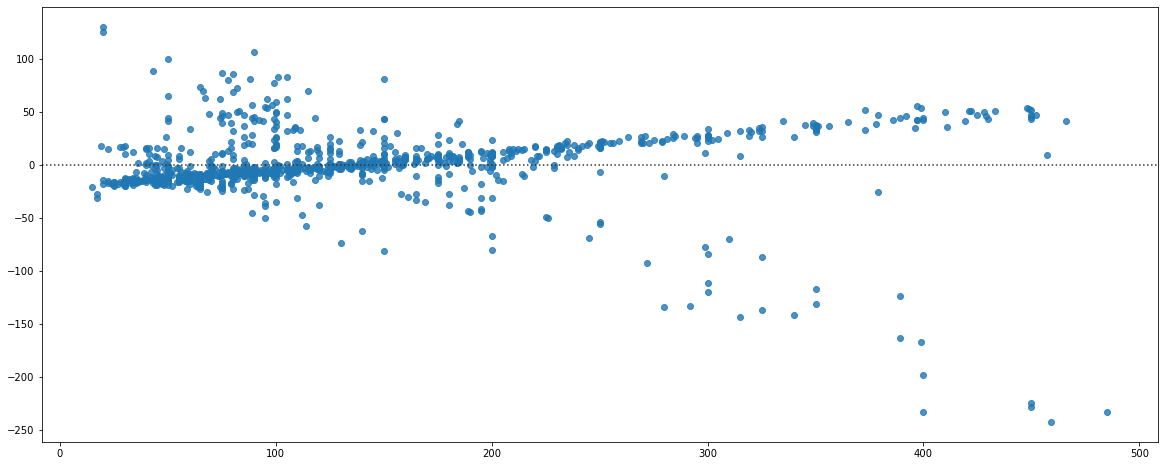

In [31]:
plt.figure(figsize=(20,8))
sns.residplot(x=y_test[:1000],y=y_pred[:1000])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        4.0000e+00, 4.0000e+00, 7.0000e+00, 1.0000e+01, 8.0000e+00,
        1.1000e+01, 8.0000e+00, 7.0000e+00, 7.0000e+00, 9.0000e+00,
        1.2000e+01, 1.1000e+01, 8.0000e+00, 5.0000e+00, 1.2000e+01,
        1.7000e+01, 1.7000e+01, 1.4000e+01, 2.3000e+01, 1.5000e+01,
        1.2000e+01, 2.7000e+01, 2.5000e+01, 2.3000e+01, 3.6000e+01,
        4.1000e+01, 3.3000e+01, 3.2000e+01, 4.1000e+01, 4.5000e+01,
        5.2000e+01, 4.6000e+01, 6.7000e+01, 6.9000e+01, 6.1000e+01,
        6.6000e+01, 7.5000e+01, 7.5000e+01, 1.2500e+02, 9.8000e+01,
        1.1300e+02, 1.4900e+02, 1.9200e+02, 2.0000e+02, 3.0100e+02,
        4.2700e+02, 6.0600e+02, 1.5830e+03, 1.1174e+04, 1.1240e+04,
        1.6300e+03, 8.7900e+02, 7.0100e+02, 5.9900e+02, 5.0000e+02,
        3.9700e+02, 3.2800e+02, 3.2100e+02, 2.53

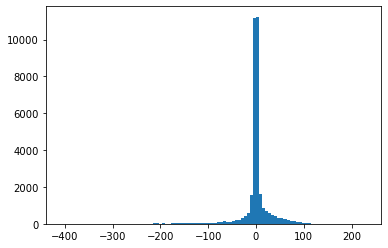

In [32]:
d=y_pred-y_test

plt.hist(d, bins=100)

Shows the most important features 

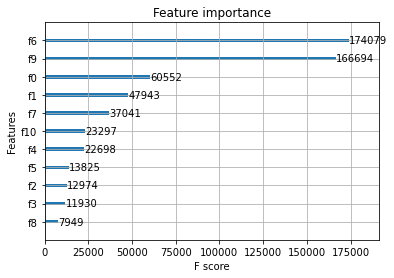

In [33]:
xgb.plot_importance(model, ax=plt.gca())
plt.show()

In [34]:
modelDS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168601 entries, 0 to 168600
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   latitude                        168601 non-null  float64
 1   longitude                       168601 non-null  float64
 2   price                           168601 non-null  int64  
 3   minimum_nights                  168601 non-null  int64  
 4   number_of_reviews               168601 non-null  int64  
 5   reviews_per_month               168601 non-null  float64
 6   calculated_host_listings_count  168601 non-null  int64  
 7   availability_365                168601 non-null  int64  
 8   room_type_ID                    168601 non-null  int64  
 9   city_ID                         168601 non-null  int64  
 10  Profit                          168601 non-null  int64  
 11  days_since_last_review          168601 non-null  int64  
dtypes: float64(3), i

removing worst predictor from previous model

In [35]:
modelDS = modelDS.drop('room_type_ID', axis =1)

In [37]:
X = modelDS.drop('price', axis = 1)
y = modelDS['price']

scaler = StandardScaler()
X =scaler.fit_transform(X)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state =20 )

In [38]:
xgModel = XGBRegressor()
xgModel.fit(X_train, y_train)
xgModel.score(X_test,y_test)

0.830528330193612

In [39]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(X_test, label = y_test)

In [40]:
params = {'learning_rate': 0.001, 'max_depth':6}
model = xgb.train(params, dtrain,evals=[(dval, 'eval')], num_boost_round = 10000, early_stopping_rounds = 10)

[0]	eval-rmse:162.99716
Will train until eval-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:162.84996
[2]	eval-rmse:162.70306
[3]	eval-rmse:162.55632
[4]	eval-rmse:162.40959
[5]	eval-rmse:162.26303
[6]	eval-rmse:162.11684
[7]	eval-rmse:161.97067
[8]	eval-rmse:161.82495
[9]	eval-rmse:161.67877
[10]	eval-rmse:161.53346
[11]	eval-rmse:161.38783
[12]	eval-rmse:161.24257
[13]	eval-rmse:161.09726
[14]	eval-rmse:160.95232
[15]	eval-rmse:160.80757
[16]	eval-rmse:160.66290
[17]	eval-rmse:160.51829
[18]	eval-rmse:160.37402
[19]	eval-rmse:160.22977
[20]	eval-rmse:160.08588
[21]	eval-rmse:159.94196
[22]	eval-rmse:159.79819
[23]	eval-rmse:159.65460
[24]	eval-rmse:159.51134
[25]	eval-rmse:159.36812
[26]	eval-rmse:159.22502
[27]	eval-rmse:159.08208
[28]	eval-rmse:158.93919
[29]	eval-rmse:158.79671
[30]	eval-rmse:158.65411
[31]	eval-rmse:158.51198
[32]	eval-rmse:158.36993
[33]	eval-rmse:158.22801
[34]	eval-rmse:158.08614
[35]	eval-rmse:157.94458
[36]	eval-rmse:157.80286
[37]	eval-rmse:157.66128
[38

[318]	eval-rmse:123.47207
[319]	eval-rmse:123.36789
[320]	eval-rmse:123.26376
[321]	eval-rmse:123.15957
[322]	eval-rmse:123.05675
[323]	eval-rmse:122.95287
[324]	eval-rmse:122.84912
[325]	eval-rmse:122.74538
[326]	eval-rmse:122.64224
[327]	eval-rmse:122.53893
[328]	eval-rmse:122.43670
[329]	eval-rmse:122.33344
[330]	eval-rmse:122.23049
[331]	eval-rmse:122.12861
[332]	eval-rmse:122.02573
[333]	eval-rmse:121.92306
[334]	eval-rmse:121.82168
[335]	eval-rmse:121.71912
[336]	eval-rmse:121.61670
[337]	eval-rmse:121.51563
[338]	eval-rmse:121.41365
[339]	eval-rmse:121.31162
[340]	eval-rmse:121.20976
[341]	eval-rmse:121.10906
[342]	eval-rmse:121.00738
[343]	eval-rmse:120.90559
[344]	eval-rmse:120.80466
[345]	eval-rmse:120.70343
[346]	eval-rmse:120.60224
[347]	eval-rmse:120.50222
[348]	eval-rmse:120.40119
[349]	eval-rmse:120.30029
[350]	eval-rmse:120.19955
[351]	eval-rmse:120.10027
[352]	eval-rmse:119.99972
[353]	eval-rmse:119.90032
[354]	eval-rmse:119.79998
[355]	eval-rmse:119.70094
[356]	eval-r

[636]	eval-rmse:95.77559
[637]	eval-rmse:95.70497
[638]	eval-rmse:95.63316
[639]	eval-rmse:95.56207
[640]	eval-rmse:95.49035
[641]	eval-rmse:95.41878
[642]	eval-rmse:95.34804
[643]	eval-rmse:95.27617
[644]	eval-rmse:95.20489
[645]	eval-rmse:95.13498
[646]	eval-rmse:95.06303
[647]	eval-rmse:94.99240
[648]	eval-rmse:94.92075
[649]	eval-rmse:94.85050
[650]	eval-rmse:94.77919
[651]	eval-rmse:94.70915
[652]	eval-rmse:94.63774
[653]	eval-rmse:94.56799
[654]	eval-rmse:94.49689
[655]	eval-rmse:94.42622
[656]	eval-rmse:94.35515
[657]	eval-rmse:94.28622
[658]	eval-rmse:94.21529
[659]	eval-rmse:94.14590
[660]	eval-rmse:94.07517
[661]	eval-rmse:94.00614
[662]	eval-rmse:93.93638
[663]	eval-rmse:93.86588
[664]	eval-rmse:93.79542
[665]	eval-rmse:93.72525
[666]	eval-rmse:93.65652
[667]	eval-rmse:93.58737
[668]	eval-rmse:93.51730
[669]	eval-rmse:93.44868
[670]	eval-rmse:93.37875
[671]	eval-rmse:93.31098
[672]	eval-rmse:93.24123
[673]	eval-rmse:93.17332
[674]	eval-rmse:93.10378
[675]	eval-rmse:93.03494


[964]	eval-rmse:76.38671
[965]	eval-rmse:76.33971
[966]	eval-rmse:76.29283
[967]	eval-rmse:76.24458
[968]	eval-rmse:76.19719
[969]	eval-rmse:76.15053
[970]	eval-rmse:76.10403
[971]	eval-rmse:76.05688
[972]	eval-rmse:76.00877
[973]	eval-rmse:75.96228
[974]	eval-rmse:75.91624
[975]	eval-rmse:75.86983
[976]	eval-rmse:75.82202
[977]	eval-rmse:75.77516
[978]	eval-rmse:75.72894
[979]	eval-rmse:75.68282
[980]	eval-rmse:75.63684
[981]	eval-rmse:75.58930
[982]	eval-rmse:75.54331
[983]	eval-rmse:75.49594
[984]	eval-rmse:75.45024
[985]	eval-rmse:75.40390
[986]	eval-rmse:75.35815
[987]	eval-rmse:75.31191
[988]	eval-rmse:75.26447
[989]	eval-rmse:75.21748
[990]	eval-rmse:75.17197
[991]	eval-rmse:75.12700
[992]	eval-rmse:75.08162
[993]	eval-rmse:75.03634
[994]	eval-rmse:74.99105
[995]	eval-rmse:74.94528
[996]	eval-rmse:74.89862
[997]	eval-rmse:74.85357
[998]	eval-rmse:74.80863
[999]	eval-rmse:74.76306
[1000]	eval-rmse:74.71659
[1001]	eval-rmse:74.67192
[1002]	eval-rmse:74.62704
[1003]	eval-rmse:74.58

[1281]	eval-rmse:64.08323
[1282]	eval-rmse:64.05256
[1283]	eval-rmse:64.02150
[1284]	eval-rmse:63.99101
[1285]	eval-rmse:63.95933
[1286]	eval-rmse:63.92878
[1287]	eval-rmse:63.89681
[1288]	eval-rmse:63.86637
[1289]	eval-rmse:63.83452
[1290]	eval-rmse:63.80438
[1291]	eval-rmse:63.77415
[1292]	eval-rmse:63.74280
[1293]	eval-rmse:63.71109
[1294]	eval-rmse:63.68093
[1295]	eval-rmse:63.65102
[1296]	eval-rmse:63.61978
[1297]	eval-rmse:63.58979
[1298]	eval-rmse:63.55979
[1299]	eval-rmse:63.52833
[1300]	eval-rmse:63.49858
[1301]	eval-rmse:63.46726
[1302]	eval-rmse:63.43743
[1303]	eval-rmse:63.40617
[1304]	eval-rmse:63.37647
[1305]	eval-rmse:63.34565
[1306]	eval-rmse:63.31618
[1307]	eval-rmse:63.28506
[1308]	eval-rmse:63.25561
[1309]	eval-rmse:63.22502
[1310]	eval-rmse:63.19552
[1311]	eval-rmse:63.16489
[1312]	eval-rmse:63.13602
[1313]	eval-rmse:63.10661
[1314]	eval-rmse:63.07623
[1315]	eval-rmse:63.04572
[1316]	eval-rmse:63.01652
[1317]	eval-rmse:62.98615
[1318]	eval-rmse:62.95720
[1319]	eval-

[1597]	eval-rmse:56.15061
[1598]	eval-rmse:56.13076
[1599]	eval-rmse:56.11104
[1600]	eval-rmse:56.09173
[1601]	eval-rmse:56.07184
[1602]	eval-rmse:56.05206
[1603]	eval-rmse:56.03245
[1604]	eval-rmse:56.01319
[1605]	eval-rmse:55.99348
[1606]	eval-rmse:55.97378
[1607]	eval-rmse:55.95464
[1608]	eval-rmse:55.93504
[1609]	eval-rmse:55.91559
[1610]	eval-rmse:55.89607
[1611]	eval-rmse:55.87700
[1612]	eval-rmse:55.85749
[1613]	eval-rmse:55.83857
[1614]	eval-rmse:55.81913
[1615]	eval-rmse:55.79968
[1616]	eval-rmse:55.78032
[1617]	eval-rmse:55.76098
[1618]	eval-rmse:55.74218
[1619]	eval-rmse:55.72305
[1620]	eval-rmse:55.70378
[1621]	eval-rmse:55.68449
[1622]	eval-rmse:55.66574
[1623]	eval-rmse:55.64671
[1624]	eval-rmse:55.62763
[1625]	eval-rmse:55.60897
[1626]	eval-rmse:55.58991
[1627]	eval-rmse:55.57085
[1628]	eval-rmse:55.55201
[1629]	eval-rmse:55.53301
[1630]	eval-rmse:55.51452
[1631]	eval-rmse:55.49559
[1632]	eval-rmse:55.47662
[1633]	eval-rmse:55.45824
[1634]	eval-rmse:55.43953
[1635]	eval-

[1913]	eval-rmse:51.10954
[1914]	eval-rmse:51.09631
[1915]	eval-rmse:51.08312
[1916]	eval-rmse:51.07031
[1917]	eval-rmse:51.05740
[1918]	eval-rmse:51.04446
[1919]	eval-rmse:51.03005
[1920]	eval-rmse:51.01779
[1921]	eval-rmse:51.00509
[1922]	eval-rmse:50.99285
[1923]	eval-rmse:50.97844
[1924]	eval-rmse:50.96623
[1925]	eval-rmse:50.95181
[1926]	eval-rmse:50.93933
[1927]	eval-rmse:50.92719
[1928]	eval-rmse:50.91503
[1929]	eval-rmse:50.90293
[1930]	eval-rmse:50.89041
[1931]	eval-rmse:50.87615
[1932]	eval-rmse:50.86408
[1933]	eval-rmse:50.85204
[1934]	eval-rmse:50.84003
[1935]	eval-rmse:50.82582
[1936]	eval-rmse:50.81384
[1937]	eval-rmse:50.80121
[1938]	eval-rmse:50.78873
[1939]	eval-rmse:50.77464
[1940]	eval-rmse:50.76202
[1941]	eval-rmse:50.75015
[1942]	eval-rmse:50.73792
[1943]	eval-rmse:50.72562
[1944]	eval-rmse:50.71334
[1945]	eval-rmse:50.69928
[1946]	eval-rmse:50.68748
[1947]	eval-rmse:50.67526
[1948]	eval-rmse:50.66347
[1949]	eval-rmse:50.65089
[1950]	eval-rmse:50.63862
[1951]	eval-

[2229]	eval-rmse:47.82402
[2230]	eval-rmse:47.81553
[2231]	eval-rmse:47.80718
[2232]	eval-rmse:47.79945
[2233]	eval-rmse:47.79105
[2234]	eval-rmse:47.78325
[2235]	eval-rmse:47.77484
[2236]	eval-rmse:47.76649
[2237]	eval-rmse:47.75876
[2238]	eval-rmse:47.75102
[2239]	eval-rmse:47.74327
[2240]	eval-rmse:47.73564
[2241]	eval-rmse:47.72747
[2242]	eval-rmse:47.71975
[2243]	eval-rmse:47.71214
[2244]	eval-rmse:47.70450
[2245]	eval-rmse:47.69620
[2246]	eval-rmse:47.68860
[2247]	eval-rmse:47.68106
[2248]	eval-rmse:47.67348
[2249]	eval-rmse:47.66535
[2250]	eval-rmse:47.65789
[2251]	eval-rmse:47.65034
[2252]	eval-rmse:47.64222
[2253]	eval-rmse:47.63438
[2254]	eval-rmse:47.62700
[2255]	eval-rmse:47.61954
[2256]	eval-rmse:47.61145
[2257]	eval-rmse:47.60329
[2258]	eval-rmse:47.59583
[2259]	eval-rmse:47.58779
[2260]	eval-rmse:47.58047
[2261]	eval-rmse:47.57247
[2262]	eval-rmse:47.56516
[2263]	eval-rmse:47.55713
[2264]	eval-rmse:47.54985
[2265]	eval-rmse:47.54220
[2266]	eval-rmse:47.53447
[2267]	eval-

[2545]	eval-rmse:45.71061
[2546]	eval-rmse:45.70549
[2547]	eval-rmse:45.70039
[2548]	eval-rmse:45.69514
[2549]	eval-rmse:45.68985
[2550]	eval-rmse:45.68476
[2551]	eval-rmse:45.67847
[2552]	eval-rmse:45.67326
[2553]	eval-rmse:45.66658
[2554]	eval-rmse:45.66149
[2555]	eval-rmse:45.65629
[2556]	eval-rmse:45.65072
[2557]	eval-rmse:45.64567
[2558]	eval-rmse:45.64050
[2559]	eval-rmse:45.63491
[2560]	eval-rmse:45.62928
[2561]	eval-rmse:45.62426
[2562]	eval-rmse:45.61926
[2563]	eval-rmse:45.61412
[2564]	eval-rmse:45.60915
[2565]	eval-rmse:45.60362
[2566]	eval-rmse:45.59853
[2567]	eval-rmse:45.59356
[2568]	eval-rmse:45.58812
[2569]	eval-rmse:45.58304
[2570]	eval-rmse:45.57739
[2571]	eval-rmse:45.57246
[2572]	eval-rmse:45.56744
[2573]	eval-rmse:45.56253
[2574]	eval-rmse:45.55696
[2575]	eval-rmse:45.55195
[2576]	eval-rmse:45.54704
[2577]	eval-rmse:45.54163
[2578]	eval-rmse:45.53674
[2579]	eval-rmse:45.53128
[2580]	eval-rmse:45.52645
[2581]	eval-rmse:45.52097
[2582]	eval-rmse:45.51604
[2583]	eval-

[2861]	eval-rmse:44.21123
[2862]	eval-rmse:44.20700
[2863]	eval-rmse:44.20328
[2864]	eval-rmse:44.19911
[2865]	eval-rmse:44.19490
[2866]	eval-rmse:44.19070
[2867]	eval-rmse:44.18795
[2868]	eval-rmse:44.18517
[2869]	eval-rmse:44.18151
[2870]	eval-rmse:44.17760
[2871]	eval-rmse:44.17487
[2872]	eval-rmse:44.17163
[2873]	eval-rmse:44.16832
[2874]	eval-rmse:44.16423
[2875]	eval-rmse:44.16100
[2876]	eval-rmse:44.15690
[2877]	eval-rmse:44.15361
[2878]	eval-rmse:44.14945
[2879]	eval-rmse:44.14585
[2880]	eval-rmse:44.14315
[2881]	eval-rmse:44.13911
[2882]	eval-rmse:44.13592
[2883]	eval-rmse:44.13196
[2884]	eval-rmse:44.12923
[2885]	eval-rmse:44.12600
[2886]	eval-rmse:44.12183
[2887]	eval-rmse:44.11777
[2888]	eval-rmse:44.11425
[2889]	eval-rmse:44.11160
[2890]	eval-rmse:44.10843
[2891]	eval-rmse:44.10519
[2892]	eval-rmse:44.10113
[2893]	eval-rmse:44.09800
[2894]	eval-rmse:44.09402
[2895]	eval-rmse:44.09123
[2896]	eval-rmse:44.08724
[2897]	eval-rmse:44.08346
[2898]	eval-rmse:44.08081
[2899]	eval-

[3177]	eval-rmse:43.21307
[3178]	eval-rmse:43.21046
[3179]	eval-rmse:43.20746
[3180]	eval-rmse:43.20417
[3181]	eval-rmse:43.20091
[3182]	eval-rmse:43.19841
[3183]	eval-rmse:43.19513
[3184]	eval-rmse:43.19306
[3185]	eval-rmse:43.19074
[3186]	eval-rmse:43.18749
[3187]	eval-rmse:43.18477
[3188]	eval-rmse:43.18153
[3189]	eval-rmse:43.17947
[3190]	eval-rmse:43.17736
[3191]	eval-rmse:43.17466
[3192]	eval-rmse:43.17263
[3193]	eval-rmse:43.16942
[3194]	eval-rmse:43.16693
[3195]	eval-rmse:43.16373
[3196]	eval-rmse:43.16167
[3197]	eval-rmse:43.15968
[3198]	eval-rmse:43.15738
[3199]	eval-rmse:43.15416
[3200]	eval-rmse:43.15148
[3201]	eval-rmse:43.14828
[3202]	eval-rmse:43.14630
[3203]	eval-rmse:43.14312
[3204]	eval-rmse:43.14068
[3205]	eval-rmse:43.13751
[3206]	eval-rmse:43.13544
[3207]	eval-rmse:43.13294
[3208]	eval-rmse:43.13090
[3209]	eval-rmse:43.12892
[3210]	eval-rmse:43.12576
[3211]	eval-rmse:43.12349
[3212]	eval-rmse:43.12034
[3213]	eval-rmse:43.11769
[3214]	eval-rmse:43.11456
[3215]	eval-

[3493]	eval-rmse:42.47280
[3494]	eval-rmse:42.47102
[3495]	eval-rmse:42.46851
[3496]	eval-rmse:42.46712
[3497]	eval-rmse:42.46510
[3498]	eval-rmse:42.46321
[3499]	eval-rmse:42.46118
[3500]	eval-rmse:42.45928
[3501]	eval-rmse:42.45723
[3502]	eval-rmse:42.45539
[3503]	eval-rmse:42.45303
[3504]	eval-rmse:42.45110
[3505]	eval-rmse:42.44908
[3506]	eval-rmse:42.44775
[3507]	eval-rmse:42.44576
[3508]	eval-rmse:42.44388
[3509]	eval-rmse:42.44233
[3510]	eval-rmse:42.43998
[3511]	eval-rmse:42.43798
[3512]	eval-rmse:42.43599
[3513]	eval-rmse:42.43464
[3514]	eval-rmse:42.43277
[3515]	eval-rmse:42.43074
[3516]	eval-rmse:42.42874
[3517]	eval-rmse:42.42677
[3518]	eval-rmse:42.42488
[3519]	eval-rmse:42.42302
[3520]	eval-rmse:42.42105
[3521]	eval-rmse:42.41926
[3522]	eval-rmse:42.41695
[3523]	eval-rmse:42.41541
[3524]	eval-rmse:42.41312
[3525]	eval-rmse:42.41122
[3526]	eval-rmse:42.40988
[3527]	eval-rmse:42.40748
[3528]	eval-rmse:42.40570
[3529]	eval-rmse:42.40328
[3530]	eval-rmse:42.40197
[3531]	eval-

[3809]	eval-rmse:41.83831
[3810]	eval-rmse:41.83722
[3811]	eval-rmse:41.83580
[3812]	eval-rmse:41.83346
[3813]	eval-rmse:41.83155
[3814]	eval-rmse:41.82904
[3815]	eval-rmse:41.82682
[3816]	eval-rmse:41.82597
[3817]	eval-rmse:41.82386
[3818]	eval-rmse:41.82165
[3819]	eval-rmse:41.81976
[3820]	eval-rmse:41.81789
[3821]	eval-rmse:41.81555
[3822]	eval-rmse:41.81342
[3823]	eval-rmse:41.81211
[3824]	eval-rmse:41.81072
[3825]	eval-rmse:41.80878
[3826]	eval-rmse:41.80653
[3827]	eval-rmse:41.80465
[3828]	eval-rmse:41.80255
[3829]	eval-rmse:41.80006
[3830]	eval-rmse:41.79784
[3831]	eval-rmse:41.79657
[3832]	eval-rmse:41.79443
[3833]	eval-rmse:41.79255
[3834]	eval-rmse:41.79036
[3835]	eval-rmse:41.78898
[3836]	eval-rmse:41.78705
[3837]	eval-rmse:41.78497
[3838]	eval-rmse:41.78281
[3839]	eval-rmse:41.78090
[3840]	eval-rmse:41.77908
[3841]	eval-rmse:41.77691
[3842]	eval-rmse:41.77445
[3843]	eval-rmse:41.77233
[3844]	eval-rmse:41.77151
[3845]	eval-rmse:41.76934
[3846]	eval-rmse:41.76748
[3847]	eval-

[4125]	eval-rmse:41.30197
[4126]	eval-rmse:41.30059
[4127]	eval-rmse:41.29792
[4128]	eval-rmse:41.29702
[4129]	eval-rmse:41.29562
[4130]	eval-rmse:41.29501
[4131]	eval-rmse:41.29327
[4132]	eval-rmse:41.29236
[4133]	eval-rmse:41.29098
[4134]	eval-rmse:41.28986
[4135]	eval-rmse:41.28719
[4136]	eval-rmse:41.28632
[4137]	eval-rmse:41.28569
[4138]	eval-rmse:41.28432
[4139]	eval-rmse:41.28163
[4140]	eval-rmse:41.28103
[4141]	eval-rmse:41.27932
[4142]	eval-rmse:41.27677
[4143]	eval-rmse:41.27587
[4144]	eval-rmse:41.27451
[4145]	eval-rmse:41.27392
[4146]	eval-rmse:41.27222
[4147]	eval-rmse:41.27085
[4148]	eval-rmse:41.26817
[4149]	eval-rmse:41.26728
[4150]	eval-rmse:41.26641
[4151]	eval-rmse:41.26472
[4152]	eval-rmse:41.26410
[4153]	eval-rmse:41.26273
[4154]	eval-rmse:41.26007
[4155]	eval-rmse:41.25922
[4156]	eval-rmse:41.25787
[4157]	eval-rmse:41.25679
[4158]	eval-rmse:41.25618
[4159]	eval-rmse:41.25355
[4160]	eval-rmse:41.25187
[4161]	eval-rmse:41.25098
[4162]	eval-rmse:41.24961
[4163]	eval-

[4441]	eval-rmse:40.86992
[4442]	eval-rmse:40.86948
[4443]	eval-rmse:40.86793
[4444]	eval-rmse:40.86680
[4445]	eval-rmse:40.86530
[4446]	eval-rmse:40.86462
[4447]	eval-rmse:40.86328
[4448]	eval-rmse:40.86173
[4449]	eval-rmse:40.86039
[4450]	eval-rmse:40.85926
[4451]	eval-rmse:40.85714
[4452]	eval-rmse:40.85663
[4453]	eval-rmse:40.85600
[4454]	eval-rmse:40.85449
[4455]	eval-rmse:40.85313
[4456]	eval-rmse:40.85178
[4457]	eval-rmse:40.85066
[4458]	eval-rmse:40.84855
[4459]	eval-rmse:40.84804
[4460]	eval-rmse:40.84738
[4461]	eval-rmse:40.84610
[4462]	eval-rmse:40.84478
[4463]	eval-rmse:40.84267
[4464]	eval-rmse:40.84215
[4465]	eval-rmse:40.84066
[4466]	eval-rmse:40.83855
[4467]	eval-rmse:40.83798
[4468]	eval-rmse:40.83666
[4469]	eval-rmse:40.83602
[4470]	eval-rmse:40.83393
[4471]	eval-rmse:40.83261
[4472]	eval-rmse:40.83197
[4473]	eval-rmse:40.82986
[4474]	eval-rmse:40.82922
[4475]	eval-rmse:40.82792
[4476]	eval-rmse:40.82584
[4477]	eval-rmse:40.82526
[4478]	eval-rmse:40.82399
[4479]	eval-

[4757]	eval-rmse:40.51695
[4758]	eval-rmse:40.51529
[4759]	eval-rmse:40.51438
[4760]	eval-rmse:40.51274
[4761]	eval-rmse:40.51185
[4762]	eval-rmse:40.51118
[4763]	eval-rmse:40.50928
[4764]	eval-rmse:40.50899
[4765]	eval-rmse:40.50787
[4766]	eval-rmse:40.50723
[4767]	eval-rmse:40.50551
[4768]	eval-rmse:40.50520
[4769]	eval-rmse:40.50353
[4770]	eval-rmse:40.50229
[4771]	eval-rmse:40.50102
[4772]	eval-rmse:40.49969
[4773]	eval-rmse:40.49939
[4774]	eval-rmse:40.49812
[4775]	eval-rmse:40.49626
[4776]	eval-rmse:40.49502
[4777]	eval-rmse:40.49441
[4778]	eval-rmse:40.49411
[4779]	eval-rmse:40.49214
[4780]	eval-rmse:40.49054
[4781]	eval-rmse:40.48931
[4782]	eval-rmse:40.48804
[4783]	eval-rmse:40.48680
[4784]	eval-rmse:40.48521
[4785]	eval-rmse:40.48494
[4786]	eval-rmse:40.48329
[4787]	eval-rmse:40.48211
[4788]	eval-rmse:40.48053
[4789]	eval-rmse:40.47935
[4790]	eval-rmse:40.47849
[4791]	eval-rmse:40.47731
[4792]	eval-rmse:40.47546
[4793]	eval-rmse:40.47516
[4794]	eval-rmse:40.47321
[4795]	eval-

[5073]	eval-rmse:40.14224
[5074]	eval-rmse:40.14095
[5075]	eval-rmse:40.14015
[5076]	eval-rmse:40.13810
[5077]	eval-rmse:40.13748
[5078]	eval-rmse:40.13545
[5079]	eval-rmse:40.13501
[5080]	eval-rmse:40.13357
[5081]	eval-rmse:40.13277
[5082]	eval-rmse:40.13132
[5083]	eval-rmse:40.13046
[5084]	eval-rmse:40.12842
[5085]	eval-rmse:40.12796
[5086]	eval-rmse:40.12653
[5087]	eval-rmse:40.12449
[5088]	eval-rmse:40.12367
[5089]	eval-rmse:40.12286
[5090]	eval-rmse:40.12149
[5091]	eval-rmse:40.12084
[5092]	eval-rmse:40.11882
[5093]	eval-rmse:40.11819
[5094]	eval-rmse:40.11774
[5095]	eval-rmse:40.11635
[5096]	eval-rmse:40.11538
[5097]	eval-rmse:40.11335
[5098]	eval-rmse:40.11289
[5099]	eval-rmse:40.11147
[5100]	eval-rmse:40.11062
[5101]	eval-rmse:40.10863
[5102]	eval-rmse:40.10841
[5103]	eval-rmse:40.10703
[5104]	eval-rmse:40.10626
[5105]	eval-rmse:40.10424
[5106]	eval-rmse:40.10354
[5107]	eval-rmse:40.10156
[5108]	eval-rmse:40.10020
[5109]	eval-rmse:40.09995
[5110]	eval-rmse:40.09910
[5111]	eval-

[5389]	eval-rmse:39.80476
[5390]	eval-rmse:39.80363
[5391]	eval-rmse:39.80223
[5392]	eval-rmse:39.80181
[5393]	eval-rmse:39.80159
[5394]	eval-rmse:39.80084
[5395]	eval-rmse:39.79923
[5396]	eval-rmse:39.79831
[5397]	eval-rmse:39.79790
[5398]	eval-rmse:39.79763
[5399]	eval-rmse:39.79616
[5400]	eval-rmse:39.79573
[5401]	eval-rmse:39.79498
[5402]	eval-rmse:39.79385
[5403]	eval-rmse:39.79226
[5404]	eval-rmse:39.79164
[5405]	eval-rmse:39.79070
[5406]	eval-rmse:39.78923
[5407]	eval-rmse:39.78877
[5408]	eval-rmse:39.78707
[5409]	eval-rmse:39.78666
[5410]	eval-rmse:39.78644
[5411]	eval-rmse:39.78554
[5412]	eval-rmse:39.78406
[5413]	eval-rmse:39.78382
[5414]	eval-rmse:39.78292
[5415]	eval-rmse:39.78260
[5416]	eval-rmse:39.78094
[5417]	eval-rmse:39.77967
[5418]	eval-rmse:39.77924
[5419]	eval-rmse:39.77850
[5420]	eval-rmse:39.77713
[5421]	eval-rmse:39.77621
[5422]	eval-rmse:39.77580
[5423]	eval-rmse:39.77558
[5424]	eval-rmse:39.77398
[5425]	eval-rmse:39.77271
[5426]	eval-rmse:39.77197
[5427]	eval-

[5705]	eval-rmse:39.54899
[5706]	eval-rmse:39.54778
[5707]	eval-rmse:39.54744
[5708]	eval-rmse:39.54720
[5709]	eval-rmse:39.54602
[5710]	eval-rmse:39.54530
[5711]	eval-rmse:39.54459
[5712]	eval-rmse:39.54343
[5713]	eval-rmse:39.54313
[5714]	eval-rmse:39.54256
[5715]	eval-rmse:39.54169
[5716]	eval-rmse:39.54047
[5717]	eval-rmse:39.54019
[5718]	eval-rmse:39.53908
[5719]	eval-rmse:39.53854
[5720]	eval-rmse:39.53791
[5721]	eval-rmse:39.53680
[5722]	eval-rmse:39.53648
[5723]	eval-rmse:39.53592
[5724]	eval-rmse:39.53473
[5725]	eval-rmse:39.53445
[5726]	eval-rmse:39.53373
[5727]	eval-rmse:39.53289
[5728]	eval-rmse:39.53173
[5729]	eval-rmse:39.53149
[5730]	eval-rmse:39.53119
[5731]	eval-rmse:39.53065
[5732]	eval-rmse:39.52927
[5733]	eval-rmse:39.52872
[5734]	eval-rmse:39.52765
[5735]	eval-rmse:39.52678
[5736]	eval-rmse:39.52558
[5737]	eval-rmse:39.52538
[5738]	eval-rmse:39.52484
[5739]	eval-rmse:39.52456
[5740]	eval-rmse:39.52385
[5741]	eval-rmse:39.52277
[5742]	eval-rmse:39.52222
[5743]	eval-

[6021]	eval-rmse:39.34444
[6022]	eval-rmse:39.34341
[6023]	eval-rmse:39.34331
[6024]	eval-rmse:39.34302
[6025]	eval-rmse:39.34197
[6026]	eval-rmse:39.34149
[6027]	eval-rmse:39.34131
[6028]	eval-rmse:39.34103
[6029]	eval-rmse:39.34050
[6030]	eval-rmse:39.33922
[6031]	eval-rmse:39.33909
[6032]	eval-rmse:39.33881
[6033]	eval-rmse:39.33827
[6034]	eval-rmse:39.33800
[6035]	eval-rmse:39.33772
[6036]	eval-rmse:39.33665
[6037]	eval-rmse:39.33618
[6038]	eval-rmse:39.33607
[6039]	eval-rmse:39.33540
[6040]	eval-rmse:39.33512
[6041]	eval-rmse:39.33485
[6042]	eval-rmse:39.33357
[6043]	eval-rmse:39.33306
[6044]	eval-rmse:39.33277
[6045]	eval-rmse:39.33251
[6046]	eval-rmse:39.33122
[6047]	eval-rmse:39.33094
[6048]	eval-rmse:39.33077
[6049]	eval-rmse:39.32971
[6050]	eval-rmse:39.32934
[6051]	eval-rmse:39.32871
[6052]	eval-rmse:39.32843
[6053]	eval-rmse:39.32817
[6054]	eval-rmse:39.32764
[6055]	eval-rmse:39.32639
[6056]	eval-rmse:39.32611
[6057]	eval-rmse:39.32600
[6058]	eval-rmse:39.32487
[6059]	eval-

[6337]	eval-rmse:39.19402
[6338]	eval-rmse:39.19299
[6339]	eval-rmse:39.19274
[6340]	eval-rmse:39.19251
[6341]	eval-rmse:39.19208
[6342]	eval-rmse:39.19169
[6343]	eval-rmse:39.19138
[6344]	eval-rmse:39.19123
[6345]	eval-rmse:39.19080
[6346]	eval-rmse:39.19070
[6347]	eval-rmse:39.19045
[6348]	eval-rmse:39.19022
[6349]	eval-rmse:39.18988
[6350]	eval-rmse:39.18946
[6351]	eval-rmse:39.18924
[6352]	eval-rmse:39.18898
[6353]	eval-rmse:39.18866
[6354]	eval-rmse:39.18845
[6355]	eval-rmse:39.18827
[6356]	eval-rmse:39.18790
[6357]	eval-rmse:39.18748
[6358]	eval-rmse:39.18727
[6359]	eval-rmse:39.18701
[6360]	eval-rmse:39.18669
[6361]	eval-rmse:39.18650
[6362]	eval-rmse:39.18620
[6363]	eval-rmse:39.18584
[6364]	eval-rmse:39.18542
[6365]	eval-rmse:39.18531
[6366]	eval-rmse:39.18509
[6367]	eval-rmse:39.18470
[6368]	eval-rmse:39.18430
[6369]	eval-rmse:39.18389
[6370]	eval-rmse:39.18355
[6371]	eval-rmse:39.18329
[6372]	eval-rmse:39.18307
[6373]	eval-rmse:39.18240
[6374]	eval-rmse:39.18171
[6375]	eval-

[6653]	eval-rmse:39.05333
[6654]	eval-rmse:39.05313
[6655]	eval-rmse:39.05209
[6656]	eval-rmse:39.05196
[6657]	eval-rmse:39.05164
[6658]	eval-rmse:39.05145
[6659]	eval-rmse:39.05027
[6660]	eval-rmse:39.05011
[6661]	eval-rmse:39.04980
[6662]	eval-rmse:39.04933
[6663]	eval-rmse:39.04913
[6664]	eval-rmse:39.04900
[6665]	eval-rmse:39.04792
[6666]	eval-rmse:39.04712
[6667]	eval-rmse:39.04671
[6668]	eval-rmse:39.04653
[6669]	eval-rmse:39.04639
[6670]	eval-rmse:39.04593
[6671]	eval-rmse:39.04560
[6672]	eval-rmse:39.04461
[6673]	eval-rmse:39.04447
[6674]	eval-rmse:39.04429
[6675]	eval-rmse:39.04347
[6676]	eval-rmse:39.04333
[6677]	eval-rmse:39.04289
[6678]	eval-rmse:39.04250
[6679]	eval-rmse:39.04232
[6680]	eval-rmse:39.04118
[6681]	eval-rmse:39.04104
[6682]	eval-rmse:39.04086
[6683]	eval-rmse:39.04053
[6684]	eval-rmse:39.03937
[6685]	eval-rmse:39.03855
[6686]	eval-rmse:39.03842
[6687]	eval-rmse:39.03800
[6688]	eval-rmse:39.03784
[6689]	eval-rmse:39.03770
[6690]	eval-rmse:39.03725
[6691]	eval-

[6969]	eval-rmse:38.93118
[6970]	eval-rmse:38.93100
[6971]	eval-rmse:38.93076
[6972]	eval-rmse:38.93060
[6973]	eval-rmse:38.92976
[6974]	eval-rmse:38.92969
[6975]	eval-rmse:38.92944
[6976]	eval-rmse:38.92912
[6977]	eval-rmse:38.92818
[6978]	eval-rmse:38.92800
[6979]	eval-rmse:38.92790
[6980]	eval-rmse:38.92749
[6981]	eval-rmse:38.92677
[6982]	eval-rmse:38.92662
[6983]	eval-rmse:38.92637
[6984]	eval-rmse:38.92594
[6985]	eval-rmse:38.92509
[6986]	eval-rmse:38.92495
[6987]	eval-rmse:38.92453
[6988]	eval-rmse:38.92362
[6989]	eval-rmse:38.92348
[6990]	eval-rmse:38.92328
[6991]	eval-rmse:38.92289
[6992]	eval-rmse:38.92262
[6993]	eval-rmse:38.92178
[6994]	eval-rmse:38.92161
[6995]	eval-rmse:38.92140
[6996]	eval-rmse:38.92110
[6997]	eval-rmse:38.92013
[6998]	eval-rmse:38.91999
[6999]	eval-rmse:38.91985
[7000]	eval-rmse:38.91890
[7001]	eval-rmse:38.91865
[7002]	eval-rmse:38.91847
[7003]	eval-rmse:38.91814
[7004]	eval-rmse:38.91724
[7005]	eval-rmse:38.91700
[7006]	eval-rmse:38.91676
[7007]	eval-

[7285]	eval-rmse:38.81979
[7286]	eval-rmse:38.81953
[7287]	eval-rmse:38.81886
[7288]	eval-rmse:38.81853
[7289]	eval-rmse:38.81788
[7290]	eval-rmse:38.81762
[7291]	eval-rmse:38.81736
[7292]	eval-rmse:38.81663
[7293]	eval-rmse:38.81639
[7294]	eval-rmse:38.81607
[7295]	eval-rmse:38.81532
[7296]	eval-rmse:38.81510
[7297]	eval-rmse:38.81469
[7298]	eval-rmse:38.81445
[7299]	eval-rmse:38.81438
[7300]	eval-rmse:38.81371
[7301]	eval-rmse:38.81349
[7302]	eval-rmse:38.81279
[7303]	eval-rmse:38.81253
[7304]	eval-rmse:38.81222
[7305]	eval-rmse:38.81198
[7306]	eval-rmse:38.81166
[7307]	eval-rmse:38.81101
[7308]	eval-rmse:38.81077
[7309]	eval-rmse:38.81033
[7310]	eval-rmse:38.81007
[7311]	eval-rmse:38.80940
[7312]	eval-rmse:38.80924
[7313]	eval-rmse:38.80850
[7314]	eval-rmse:38.80825
[7315]	eval-rmse:38.80799
[7316]	eval-rmse:38.80768
[7317]	eval-rmse:38.80694
[7318]	eval-rmse:38.80673
[7319]	eval-rmse:38.80602
[7320]	eval-rmse:38.80561
[7321]	eval-rmse:38.80554
[7322]	eval-rmse:38.80531
[7323]	eval-

[7601]	eval-rmse:38.70224
[7602]	eval-rmse:38.70203
[7603]	eval-rmse:38.70163
[7604]	eval-rmse:38.70144
[7605]	eval-rmse:38.70123
[7606]	eval-rmse:38.70083
[7607]	eval-rmse:38.70024
[7608]	eval-rmse:38.69960
[7609]	eval-rmse:38.69914
[7610]	eval-rmse:38.69897
[7611]	eval-rmse:38.69866
[7612]	eval-rmse:38.69806
[7613]	eval-rmse:38.69796
[7614]	eval-rmse:38.69757
[7615]	eval-rmse:38.69733
[7616]	eval-rmse:38.69670
[7617]	eval-rmse:38.69661
[7618]	eval-rmse:38.69640
[7619]	eval-rmse:38.69616
[7620]	eval-rmse:38.69558
[7621]	eval-rmse:38.69515
[7622]	eval-rmse:38.69506
[7623]	eval-rmse:38.69485
[7624]	eval-rmse:38.69464
[7625]	eval-rmse:38.69399
[7626]	eval-rmse:38.69380
[7627]	eval-rmse:38.69370
[7628]	eval-rmse:38.69350
[7629]	eval-rmse:38.69273
[7630]	eval-rmse:38.69235
[7631]	eval-rmse:38.69225
[7632]	eval-rmse:38.69203
[7633]	eval-rmse:38.69161
[7634]	eval-rmse:38.69105
[7635]	eval-rmse:38.69059
[7636]	eval-rmse:38.69038
[7637]	eval-rmse:38.68974
[7638]	eval-rmse:38.68965
[7639]	eval-

[7917]	eval-rmse:38.60507
[7918]	eval-rmse:38.60483
[7919]	eval-rmse:38.60460
[7920]	eval-rmse:38.60438
[7921]	eval-rmse:38.60429
[7922]	eval-rmse:38.60397
[7923]	eval-rmse:38.60344
[7924]	eval-rmse:38.60314
[7925]	eval-rmse:38.60305
[7926]	eval-rmse:38.60277
[7927]	eval-rmse:38.60255
[7928]	eval-rmse:38.60245
[7929]	eval-rmse:38.60183
[7930]	eval-rmse:38.60124
[7931]	eval-rmse:38.60115
[7932]	eval-rmse:38.60086
[7933]	eval-rmse:38.60013
[7934]	eval-rmse:38.59977
[7935]	eval-rmse:38.59953
[7936]	eval-rmse:38.59943
[7937]	eval-rmse:38.59884
[7938]	eval-rmse:38.59875
[7939]	eval-rmse:38.59796
[7940]	eval-rmse:38.59774
[7941]	eval-rmse:38.59750
[7942]	eval-rmse:38.59741
[7943]	eval-rmse:38.59681
[7944]	eval-rmse:38.59673
[7945]	eval-rmse:38.59620
[7946]	eval-rmse:38.59597
[7947]	eval-rmse:38.59578
[7948]	eval-rmse:38.59548
[7949]	eval-rmse:38.59539
[7950]	eval-rmse:38.59520
[7951]	eval-rmse:38.59483
[7952]	eval-rmse:38.59403
[7953]	eval-rmse:38.59388
[7954]	eval-rmse:38.59376
[7955]	eval-

[8233]	eval-rmse:38.50740
[8234]	eval-rmse:38.50722
[8235]	eval-rmse:38.50713
[8236]	eval-rmse:38.50666
[8237]	eval-rmse:38.50617
[8238]	eval-rmse:38.50609
[8239]	eval-rmse:38.50561
[8240]	eval-rmse:38.50552
[8241]	eval-rmse:38.50534
[8242]	eval-rmse:38.50526
[8243]	eval-rmse:38.50489
[8244]	eval-rmse:38.50426
[8245]	eval-rmse:38.50417
[8246]	eval-rmse:38.50407
[8247]	eval-rmse:38.50361
[8248]	eval-rmse:38.50320
[8249]	eval-rmse:38.50273
[8250]	eval-rmse:38.50263
[8251]	eval-rmse:38.50225
[8252]	eval-rmse:38.50163
[8253]	eval-rmse:38.50153
[8254]	eval-rmse:38.50116
[8255]	eval-rmse:38.50107
[8256]	eval-rmse:38.50068
[8257]	eval-rmse:38.50008
[8258]	eval-rmse:38.49998
[8259]	eval-rmse:38.49994
[8260]	eval-rmse:38.49957
[8261]	eval-rmse:38.49901
[8262]	eval-rmse:38.49892
[8263]	eval-rmse:38.49854
[8264]	eval-rmse:38.49808
[8265]	eval-rmse:38.49798
[8266]	eval-rmse:38.49762
[8267]	eval-rmse:38.49715
[8268]	eval-rmse:38.49656
[8269]	eval-rmse:38.49638
[8270]	eval-rmse:38.49628
[8271]	eval-

[8549]	eval-rmse:38.40699
[8550]	eval-rmse:38.40658
[8551]	eval-rmse:38.40606
[8552]	eval-rmse:38.40557
[8553]	eval-rmse:38.40500
[8554]	eval-rmse:38.40493
[8555]	eval-rmse:38.40444
[8556]	eval-rmse:38.40435
[8557]	eval-rmse:38.40394
[8558]	eval-rmse:38.40344
[8559]	eval-rmse:38.40296
[8560]	eval-rmse:38.40290
[8561]	eval-rmse:38.40280
[8562]	eval-rmse:38.40238
[8563]	eval-rmse:38.40225
[8564]	eval-rmse:38.40211
[8565]	eval-rmse:38.40172
[8566]	eval-rmse:38.40120
[8567]	eval-rmse:38.40109
[8568]	eval-rmse:38.40057
[8569]	eval-rmse:38.40043
[8570]	eval-rmse:38.40039
[8571]	eval-rmse:38.40007
[8572]	eval-rmse:38.39999
[8573]	eval-rmse:38.39993
[8574]	eval-rmse:38.39937
[8575]	eval-rmse:38.39888
[8576]	eval-rmse:38.39885
[8577]	eval-rmse:38.39832
[8578]	eval-rmse:38.39778
[8579]	eval-rmse:38.39739
[8580]	eval-rmse:38.39691
[8581]	eval-rmse:38.39683
[8582]	eval-rmse:38.39669
[8583]	eval-rmse:38.39641
[8584]	eval-rmse:38.39602
[8585]	eval-rmse:38.39551
[8586]	eval-rmse:38.39540
[8587]	eval-

[8865]	eval-rmse:38.31213
[8866]	eval-rmse:38.31168
[8867]	eval-rmse:38.31152
[8868]	eval-rmse:38.31125
[8869]	eval-rmse:38.31090
[8870]	eval-rmse:38.31031
[8871]	eval-rmse:38.31017
[8872]	eval-rmse:38.30998
[8873]	eval-rmse:38.30954
[8874]	eval-rmse:38.30950
[8875]	eval-rmse:38.30940
[8876]	eval-rmse:38.30903
[8877]	eval-rmse:38.30853
[8878]	eval-rmse:38.30810
[8879]	eval-rmse:38.30779
[8880]	eval-rmse:38.30748
[8881]	eval-rmse:38.30713
[8882]	eval-rmse:38.30655
[8883]	eval-rmse:38.30642
[8884]	eval-rmse:38.30624
[8885]	eval-rmse:38.30574
[8886]	eval-rmse:38.30538
[8887]	eval-rmse:38.30487
[8888]	eval-rmse:38.30477
[8889]	eval-rmse:38.30423
[8890]	eval-rmse:38.30379
[8891]	eval-rmse:38.30370
[8892]	eval-rmse:38.30339
[8893]	eval-rmse:38.30308
[8894]	eval-rmse:38.30250
[8895]	eval-rmse:38.30220
[8896]	eval-rmse:38.30204
[8897]	eval-rmse:38.30170
[8898]	eval-rmse:38.30112
[8899]	eval-rmse:38.30094
[8900]	eval-rmse:38.30050
[8901]	eval-rmse:38.30036
[8902]	eval-rmse:38.30011
[8903]	eval-

[9181]	eval-rmse:38.22325
[9182]	eval-rmse:38.22297
[9183]	eval-rmse:38.22294
[9184]	eval-rmse:38.22263
[9185]	eval-rmse:38.22257
[9186]	eval-rmse:38.22252
[9187]	eval-rmse:38.22219
[9188]	eval-rmse:38.22175
[9189]	eval-rmse:38.22166
[9190]	eval-rmse:38.22136
[9191]	eval-rmse:38.22120
[9192]	eval-rmse:38.22089
[9193]	eval-rmse:38.22081
[9194]	eval-rmse:38.22047
[9195]	eval-rmse:38.22036
[9196]	eval-rmse:38.22026
[9197]	eval-rmse:38.22023
[9198]	eval-rmse:38.22002
[9199]	eval-rmse:38.21979
[9200]	eval-rmse:38.21975
[9201]	eval-rmse:38.21970
[9202]	eval-rmse:38.21941
[9203]	eval-rmse:38.21914
[9204]	eval-rmse:38.21911
[9205]	eval-rmse:38.21877
[9206]	eval-rmse:38.21832
[9207]	eval-rmse:38.21825
[9208]	eval-rmse:38.21795
[9209]	eval-rmse:38.21789
[9210]	eval-rmse:38.21756
[9211]	eval-rmse:38.21748
[9212]	eval-rmse:38.21703
[9213]	eval-rmse:38.21688
[9214]	eval-rmse:38.21680
[9215]	eval-rmse:38.21649
[9216]	eval-rmse:38.21617
[9217]	eval-rmse:38.21605
[9218]	eval-rmse:38.21600
[9219]	eval-

[9497]	eval-rmse:38.15987
[9498]	eval-rmse:38.15982
[9499]	eval-rmse:38.15966
[9500]	eval-rmse:38.15913
[9501]	eval-rmse:38.15889
[9502]	eval-rmse:38.15866
[9503]	eval-rmse:38.15864
[9504]	eval-rmse:38.15849
[9505]	eval-rmse:38.15813
[9506]	eval-rmse:38.15781
[9507]	eval-rmse:38.15732
[9508]	eval-rmse:38.15700
[9509]	eval-rmse:38.15676
[9510]	eval-rmse:38.15623
[9511]	eval-rmse:38.15608
[9512]	eval-rmse:38.15606
[9513]	eval-rmse:38.15569
[9514]	eval-rmse:38.15534
[9515]	eval-rmse:38.15530
[9516]	eval-rmse:38.15480
[9517]	eval-rmse:38.15463
[9518]	eval-rmse:38.15427
[9519]	eval-rmse:38.15423
[9520]	eval-rmse:38.15400
[9521]	eval-rmse:38.15364
[9522]	eval-rmse:38.15348
[9523]	eval-rmse:38.15317
[9524]	eval-rmse:38.15269
[9525]	eval-rmse:38.15234
[9526]	eval-rmse:38.15229
[9527]	eval-rmse:38.15204
[9528]	eval-rmse:38.15169
[9529]	eval-rmse:38.15151
[9530]	eval-rmse:38.15148
[9531]	eval-rmse:38.15113
[9532]	eval-rmse:38.15064
[9533]	eval-rmse:38.15029
[9534]	eval-rmse:38.15013
[9535]	eval-

[9813]	eval-rmse:38.08261
[9814]	eval-rmse:38.08235
[9815]	eval-rmse:38.08204
[9816]	eval-rmse:38.08184
[9817]	eval-rmse:38.08137
[9818]	eval-rmse:38.08134
[9819]	eval-rmse:38.08131
[9820]	eval-rmse:38.08107
[9821]	eval-rmse:38.08083
[9822]	eval-rmse:38.08045
[9823]	eval-rmse:38.08027
[9824]	eval-rmse:38.08006
[9825]	eval-rmse:38.07980
[9826]	eval-rmse:38.07967
[9827]	eval-rmse:38.07966
[9828]	eval-rmse:38.07947
[9829]	eval-rmse:38.07920
[9830]	eval-rmse:38.07904
[9831]	eval-rmse:38.07872
[9832]	eval-rmse:38.07825
[9833]	eval-rmse:38.07800
[9834]	eval-rmse:38.07798
[9835]	eval-rmse:38.07773
[9836]	eval-rmse:38.07751
[9837]	eval-rmse:38.07735
[9838]	eval-rmse:38.07689
[9839]	eval-rmse:38.07687
[9840]	eval-rmse:38.07665
[9841]	eval-rmse:38.07639
[9842]	eval-rmse:38.07629
[9843]	eval-rmse:38.07605
[9844]	eval-rmse:38.07566
[9845]	eval-rmse:38.07564
[9846]	eval-rmse:38.07539
[9847]	eval-rmse:38.07536
[9848]	eval-rmse:38.07498
[9849]	eval-rmse:38.07477
[9850]	eval-rmse:38.07456
[9851]	eval-

In [41]:
y_true = np.array(y_test, dtype=np.float64)
y_pred = np.array(model.predict(dtest), dtype=np.float64)
print("MSE Score: {:.4f}" .format(mean_squared_error(y_true, y_pred)))
print("RMSE Score: {:.4f}" .format(sqrt(mean_squared_error(y_true, y_pred))))

MSE Score: 1415.9583
RMSE Score: 37.6292


<AxesSubplot:>

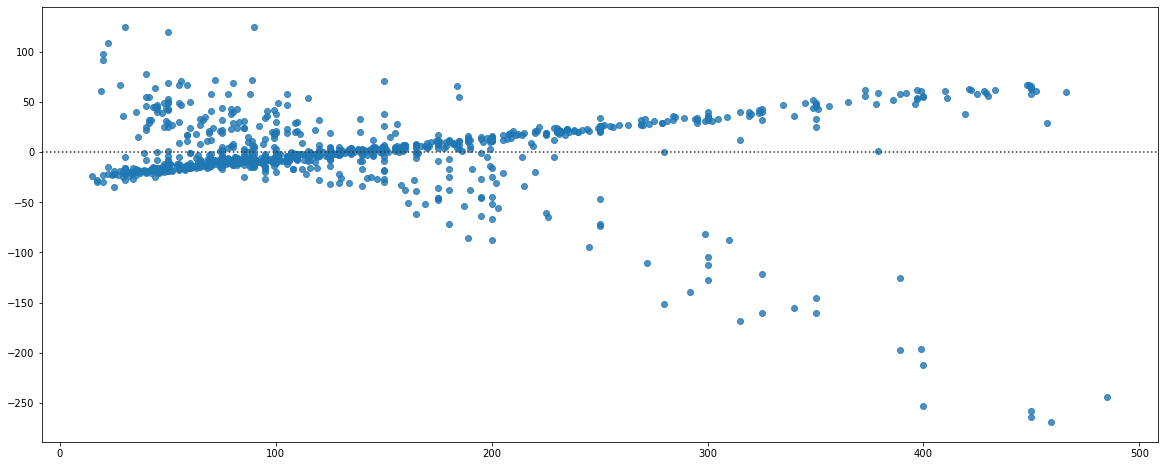

In [42]:
plt.figure(figsize=(20,8))
sns.residplot(x=y_test[:1000],y=y_pred[:1000])

(array([2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        4.0000e+00, 4.0000e+00, 5.0000e+00, 2.0000e+00, 1.3000e+01,
        2.0000e+00, 8.0000e+00, 5.0000e+00, 6.0000e+00, 7.0000e+00,
        8.0000e+00, 6.0000e+00, 8.0000e+00, 1.3000e+01, 8.0000e+00,
        1.3000e+01, 1.2000e+01, 2.0000e+00, 1.1000e+01, 1.0000e+01,
        9.0000e+00, 1.2000e+01, 1.8000e+01, 2.0000e+01, 1.4000e+01,
        1.8000e+01, 2.0000e+01, 2.5000e+01, 2.0000e+01, 2.3000e+01,
        2.5000e+01, 3.0000e+01, 3.7000e+01, 3.3000e+01, 3.2000e+01,
        2.9000e+01, 3.4000e+01, 2.8000e+01, 5.2000e+01, 5.5000e+01,
        3.9000e+01, 4.8000e+01, 4.0000e+01, 6.1000e+01, 5.7000e+01,
        7.1000e+01, 8.0000e+01, 8.5000e+01, 1.0700e+02, 9.9000e+01,
        1.0900e+02, 1.1000e+02, 1.2300e+02, 1.5300e+02, 1.5700e+02,
        1.9900e+02, 2.2400e+02, 2.4700e+02, 4.0500e+02, 8.4900e+02,
        3.6890e+03, 1.7541e+04, 2.8570e+03, 7.6500e+02, 5.1800e+02,
        4.6200e+02, 4.6000e+02, 4.1200e+02, 4.40

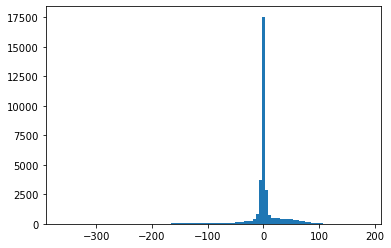

In [43]:
d=y_pred-y_test

plt.hist(d, bins=100)

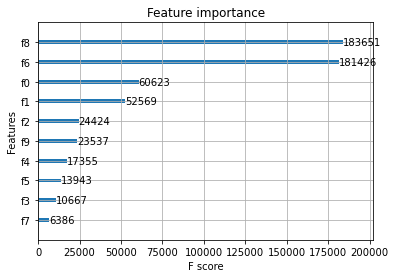

In [44]:
xgb.plot_importance(model, ax=plt.gca())
plt.show()

With the removal of the worst feature the model preformed worse. Due to this we will keep all the features for the final model that we will select.

### After our model buidling exporation. We recommend that you select an XGBoost as your best model
We recommend an XGBoost because it performed at a higher accuracy than the decision tree and did not forfeit enough time to make it not worth the accuracy.